# Genomic surveillance analysis in Germany

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


In [2]:
from genomicsurveillance.misc import ancestor_matrix, alias

## Download data
### Map
With zip codes for geo matching

In [3]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
if 'plz' not in locals():
    plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
    bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [4]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 61.4M  100 61.4M    0     0  7015k      0  0:00:08  0:00:08 --:--:-- 11.3M
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 23.1M  100 23.1M    0     0  7233k      0  0:00:03  0:00:03 --:--:-- 12.5M
+ bash scripts/

In [5]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [6]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [7]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [8]:
df.reason.value_counts()

N                             589773
X                             340249
Y                              39730
A[B.1.617.2]                   35864
A[B.1.1.7]                     35832
                               ...  
A[E484K/N501Y/P681R]               0
A[E484E/N501N/P681P]               0
A[N501Y/E484K]                     0
A[KONTAKTMITENGL.MUTATION]         0
A[E484E/N501N/P681R]               0
Name: reason, Length: 232, dtype: int64

In [9]:
import re

In [10]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD... 2022-08-23      Y   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9... 2022-08-30      Y   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40... 2022-08-30      Y   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890... 2022-08-30      Y   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823... 2022-08-16      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...      2022-09-21      55131   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...      2022-09-21      55131   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...      2022-09-21      55131   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...      2022-09-21      55131   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...      2022-08-22      33617   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                       40225  B.1.1.297   
IMS-10294-CVDP-00325                                       40225    B.1.221   
IMS-10294-CVDP-00326                                       40225    B.1.160   
IMS-10294-CVDP-00327                                       40225    B.1.258   
IMS-10294-CVDP-00329                                       40225  B.1.1.521   
...                                                          ...        ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...         55131   BA.5.1.2   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...         55131     BA.5.1   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...         55131   BA.5.1.2   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...         55131   BA.5.1.2   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...         24106     BA.5.2   

                                                   scorpio  \
IMS_ID                                                       
IMS-10294-CVDP-00001                                   NaN   
IMS-10294-CVDP-00325                                   NaN   
IMS-10294-CVDP-00326                                   NaN   
IMS-10294-CVDP-00327                                   NaN   
IMS-10294-CVDP-00329                                   NaN   
...                                                    ...   
IMS-10594-CVDP-CE8299E7-659A-476E-B2A2-5DBB2BCD...     NaN   
IMS-10594-CVDP-76A84CA4-0B43-4F05-BEED-F76CF7F9...     NaN   
IMS-10594-CVDP-45DCC9DB-98F1-4770-896C-8CAE1C40...     NaN   
IMS-10594-CVDP-FA5ACBE9-879E-4967-9251-8B4E3890...     NaN   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...     NaN   

                                                             bundesland  
IMS_ID                                                                   
IMS-10294-CVDP-00001                                Nordrhein-Westfalen  
IMS-10294

In [11]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5.2       2821
BA.5.1       2090
BA.5.2.1     1439
BE.1.1       1007
BF.7          725
             ... 
BA.5.6.1        1
BA.5.10         1
BA.2.74         1
BA.2.3.7        1
BA.2.40.1       1
Name: lineage, Length: 86, dtype: int64

In [12]:
start_date = "2021-01-01"
d = df.loc[df.date >= start_date,:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [13]:
ba = [x for x in l if alias(x, anti_alias=True).startswith('B.1.1.529') ]
#ba

In [14]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
#d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories()#.cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       A.19  A.2.5  A.2.5.2  A.23.1  A.27  A.28  A.29  \
bundesland        date                                                         
Baden-Württemberg 2021-01-01     0      0        0       0     0     0     0   
                  2021-01-02     0      0        0       0     0     0     0   
                  2021-01-03     0      0        0       0     0     0     0   
                  2021-01-04     0      0        0       0     0     0     0   
                  2021-01-05     0      0        0       0     0     0     0   
...                            ...    ...      ...     ...   ...   ...   ...   
Thüringen         2022-09-17     0      0        0       0     0     0     0   
                  2022-09-18     0      0        0       0     0     0     0   
                  2022-09-19     0      0        0       0     0     0     0   
                  2022-09-20     0      0        0       0     0     0     0   
                  2022-09-22     0      0        0       0     0     0     0   

lineage                       AA.1  AF.1  AG.1  ...  BA.5.6.1  BA.5.6.2  \
bundesland        date                          ...                       
Baden-Württemberg 2021-01-01     0     0     0  ...         0         0   
                  2021-01-02     0     0     0  ...         0         0   
                  2021-01-03     0     0     0  ...         0         0   
                  2021-01-04     0     0     0  ...         0         0   
                  2021-01-05     0     0     0  ...         0         0   
...                            ...   ...   ...  ...       ...       ...   
Thüringen         2022-09-17     0     0     0  ...         0         0   
                  2022-09-18     0     0     0  ...         0         0   
                  2022-09-19     0     0     0  ...         0         0   
                  2022-09-20     0     0     0  ...         0         0   
                  2022-09-22     0     0     0  ...         0         0   

lineage                       BE.1.2  BF.13  BF.9  BH.1  BK.1  XAJ  BA.2.10.4  \
bundesland        date                                                          
Baden-Württemberg 2021-01-01       0      0     0     0     0    0          0   
                  2021-01-02       0      0     0     0     0    0          0   
                  2021-01-03       0      0     0     0     0    0          0   
                  2021-01-04       0      0     0     0     0    0          0   
                  2021-01-05       0      0     0     0     0    0          0   
...                              ...    ...   ...   ...   ...  ...        ...   
Thüringen         2022-09-17       0      0     0     0     0    0          0   
                  2022-09-18       0      0     0     0     0    0          0   
                  2022-09-19       0      0     0     0     0    0          0   
                  2022-09-20       0      0     0     0     0    0          0   
                  2022-09-22       0      0     0     0     0    0          0   

lineage                       A  
bundesland        date           
Baden-Württemberg 2021-01-01  0  
                  2021-01-02  0  
                  2021-01-03  0  
                  2021-01-04  0  
                  2021-01-05  0  
...                          ..  
Thüringen         2022-09-17  0  
                  2022-09-18  0  
                  2022-09-19  0  
                  2022-09-20  0  
                  2022-09-22  0  

[10064 rows x 711 columns]

In [15]:
with pd.option_context('display.max_rows', None,):
    print(genomes.sum(level=1).loc["2022-06-01":,[x for x in genomes.columns if x.startswith("BA.2.75")]])

lineage     BA.2.75  BA.2.75.1  BA.2.75.2  BA.2.75.5
date                                                
2022-06-01        0          0          0          0
2022-06-02        0          0          0          0
2022-06-03        1          0          0          0
2022-06-04        0          0          0          0
2022-06-05        0          0          0          0
2022-06-06        1          0          0          0
2022-06-07        0          0          0          0
2022-06-08        0          0          0          0
2022-06-09        0          0          0          0
2022-06-10        0          0          0          0
2022-06-11        0          0          0          0
2022-06-12        0          0          0          0
2022-06-13        0          0          0          0
2022-06-14        0          0          0          0
2022-06-15        0          0          0          0
2022-06-16        0          0          0          0
2022-06-17        0          0          0     

Text(0, 0.5, '14d log odds Aug 1-15 / Jul 15-30')

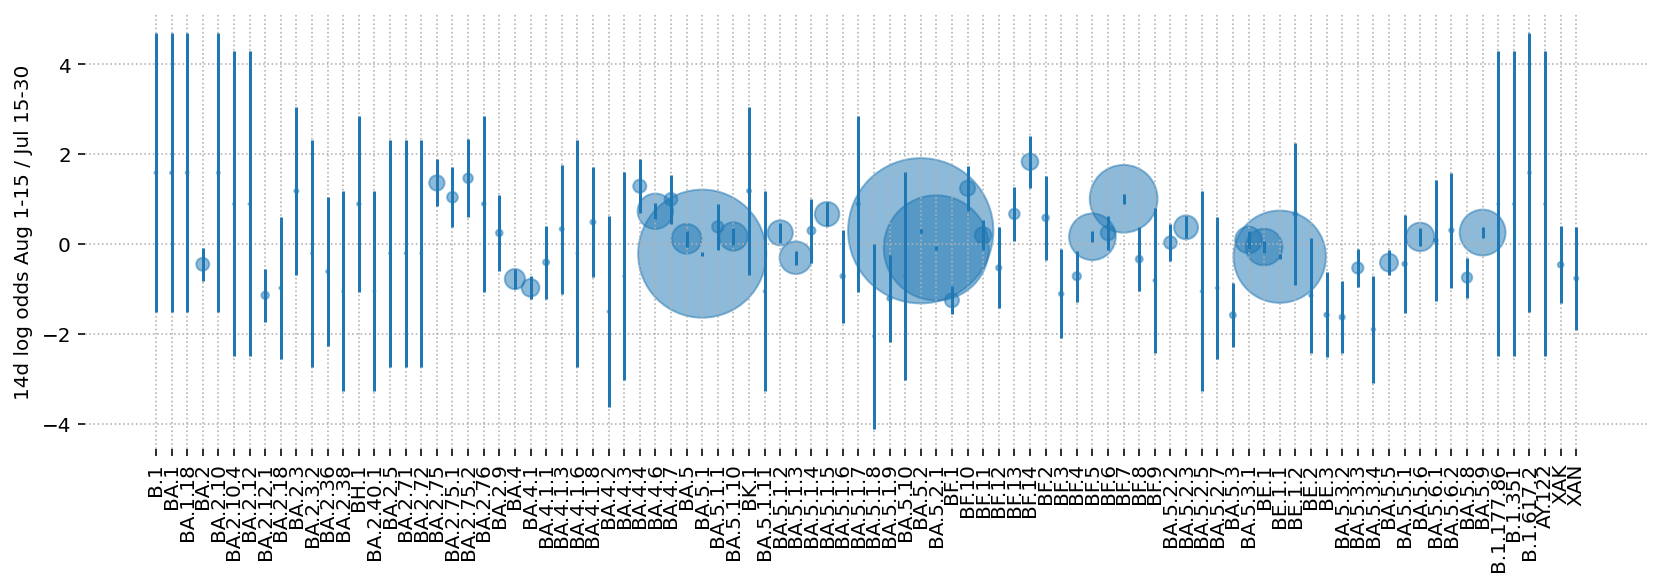

In [16]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.iloc[-28:].sum(0) #+.5
i = g.iloc[-56:-28].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(14,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

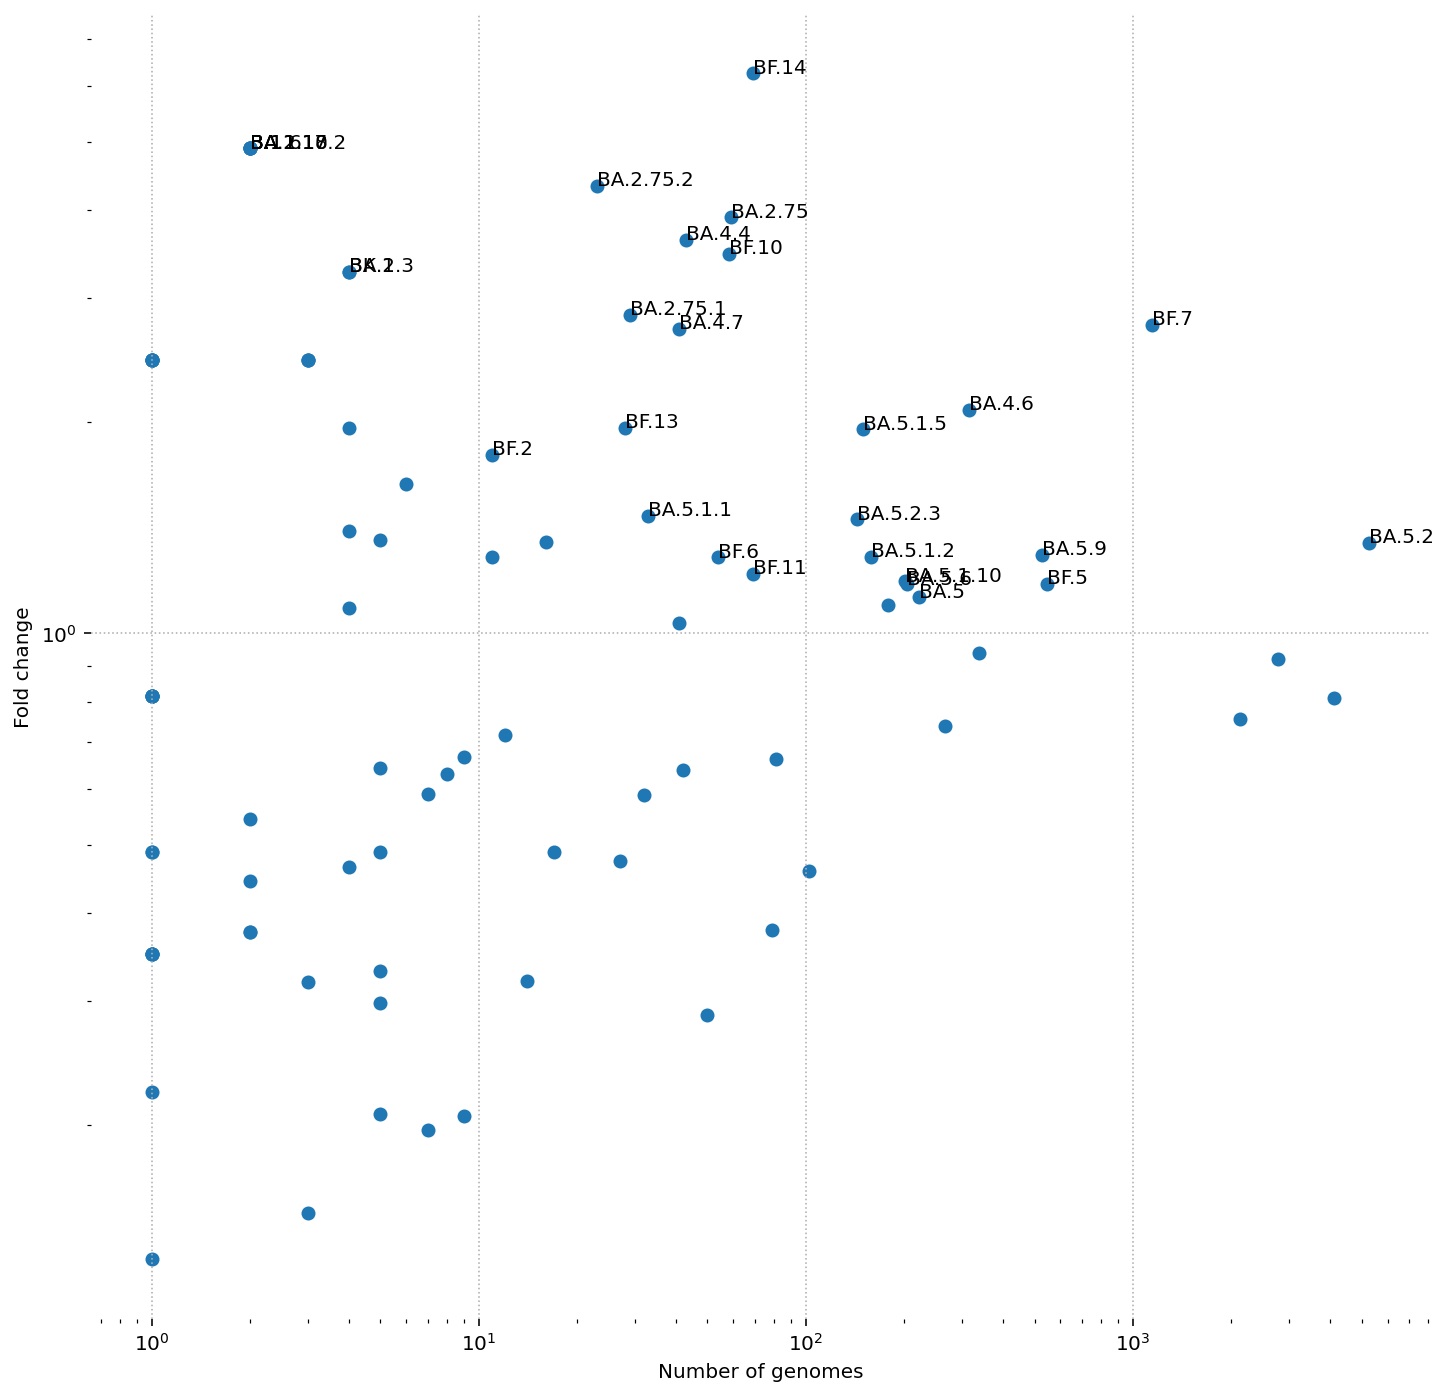

In [17]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

(19083.0, 19288.45)

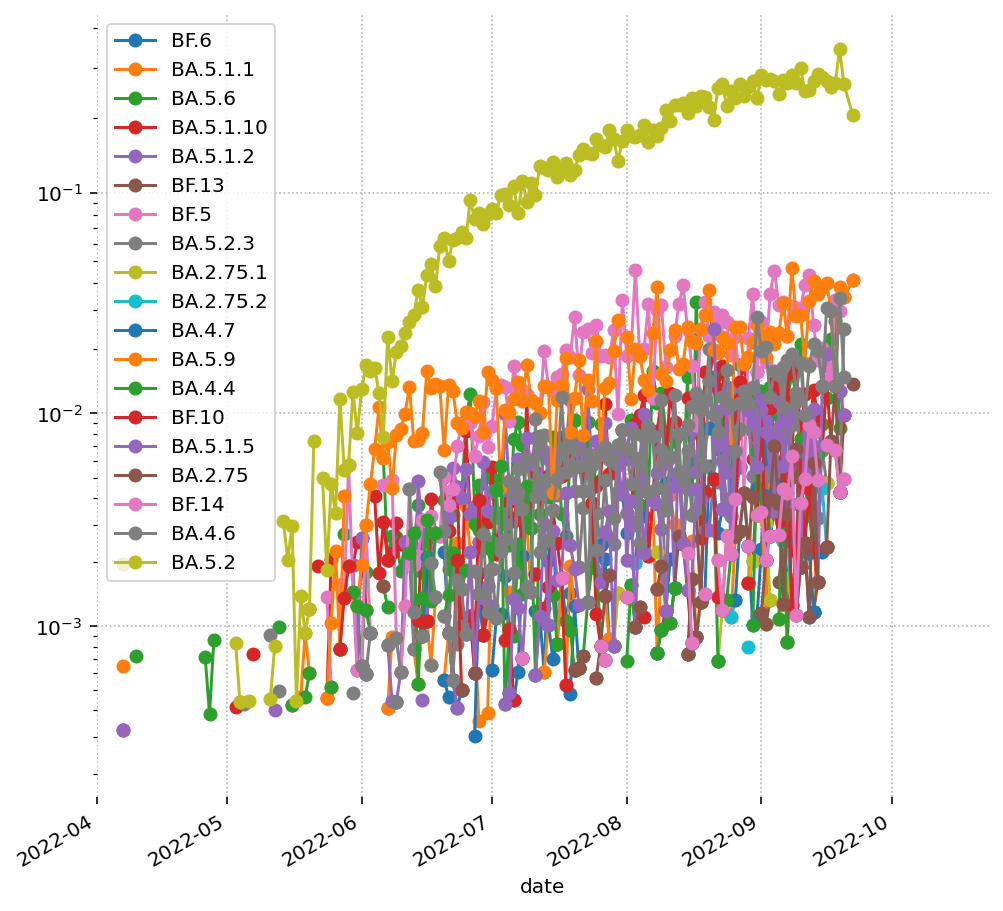

In [18]:
plt.figure(figsize=(8,8))
plt.set_cmap('tab20')
for i,v in enumerate((np.log(f)/e[f.index]).sort_values()[-20:-1].index.to_list() ):
    if g[v].sum()>=20:
        (g[v]/g.sum(1)+0).plot(label=v, ls="-", marker="o")
plt.yscale('logit')
#plt.show()
plt.legend()
plt.xlim(("2022-04-01",None))

In [135]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=bq.1&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[{'date': '2022-09-15', 'count': 2},
 {'date': '2022-09-03', 'count': 1},
 {'date': '2022-09-05', 'count': 2},
 {'date': '2022-09-07', 'count': 3},
 {'date': '2022-08-23', 'count': 1},
 {'date': '2022-09-08', 'count': 1},
 {'date': '2022-08-24', 'count': 1},
 {'date': '2022-09-09', 'count': 3},
 {'date': '2022-09-11', 'count': 3},
 {'date': '2022-09-12', 'count': 3}]

In [136]:
bar = pd.DataFrame.from_dict(foo).set_index('date')
bar.index = pd.DatetimeIndex(bar.index)
bq1 = pd.merge(bar,genomes.loc['Baden-Württemberg'],left_index=True, right_index=True, how='right')['count'].fillna(0).astype('int')
bq1

date
2021-01-01    0
2021-01-02    0
2021-01-03    0
2021-01-04    0
2021-01-05    0
             ..
2022-09-17    0
2022-09-18    0
2022-09-19    0
2022-09-20    0
2022-09-22    0
Name: count, Length: 629, dtype: int64

In [19]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=bq.1*&aaMutations=S%3A346T&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[{'date': '2022-09-15', 'count': 3},
 {'date': '2022-09-17', 'count': 3},
 {'date': '2022-09-19', 'count': 2},
 {'date': '2022-09-09', 'count': 1},
 {'date': '2022-08-24', 'count': 1},
 {'date': '2022-09-10', 'count': 1},
 {'date': '2022-09-11', 'count': 1}]

In [21]:
bar = pd.DataFrame.from_dict(foo).set_index('date')
bar.index = pd.DatetimeIndex(bar.index)
bq11 = pd.merge(bar,genomes.loc['Baden-Württemberg'],left_index=True, right_index=True, how='right')['count'].fillna(0).astype('int')
bq11

date
2021-01-01    0
2021-01-02    0
2021-01-03    0
2021-01-04    0
2021-01-05    0
             ..
2022-09-17    3
2022-09-18    0
2022-09-19    2
2022-09-20    0
2022-09-22    0
Name: count, Length: 629, dtype: int64

In [138]:
genomes.columns=genomes.columns.add_categories(['BQ.1','BQ.1.1'])

In [23]:
genomes.insert(0,column='BQ.1.1', value=0)
genomes.loc['Baden-Württemberg']['BQ.1.1'] = bq11
genomes.loc['Baden-Württemberg']['BA.5'] -= bq11 

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
genomes.insert(0,column='BQ.1', value=0)
genomes.loc['Baden-Württemberg']['BQ.1'] = bq1
genomes.loc['Baden-Württemberg']['BA.5'] -= bq1

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [140]:
genomes.loc['Baden-Württemberg'][['BQ.1','BQ.1.1']] 

lineage     BQ.1  BQ.1.1
date                    
2021-01-01     0       0
2021-01-02     0       0
2021-01-03     0       0
2021-01-04     0       0
2021-01-05     0       0
...          ...     ...
2022-09-17     0       3
2022-09-18     0       0
2022-09-19     0       2
2022-09-20     0       0
2022-09-22     0       0

[629 rows x 2 columns]

In [25]:
url = "https://dev-lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?country=Germany&dateFrom=2022-06-20&nextcladePangoLineage=ba.2.3.20&host=Human&accessKey=9Cb3CqmrFnVjO3XCxQLO6gUnKPd&fields=date"
import json, requests
foo = json.loads(requests.get(url).text)['data']
foo

[{'date': '2022-09-14', 'count': 2}, {'date': '2022-09-05', 'count': 1}]

In [26]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/series.py:1008: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [27]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [28]:
genomes.loc[:,"BA.2.75"].sum(level=0)

bundesland
Baden-Württemberg         33
Bayern                    17
Berlin                     2
Brandenburg                2
Bremen                     0
Hamburg                    2
Hessen                     0
Mecklenburg-Vorpommern     2
Niedersachsen              9
Nordrhein-Westfalen       12
Rheinland-Pfalz            2
Saarland                   1
Sachsen                    5
Sachsen-Anhalt             0
Schleswig-Holstein         2
Thüringen                  0
Name: BA.2.75, dtype: int64

In [143]:
import importlib
importlib.reload(gs.utils)
importlib.reload(gs)
from genomicsurveillance.utils import preprocess_lineage_tensor

In [144]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [145]:
lineages = genomes.columns.to_list()

In [146]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 6), match='BQ.1.1'>

In [147]:
foo =d.lineage.value_counts()[:200]
bar = [d.date[d.lineage==l].sort_values()[10] for l in foo.index]
bak = pd.DataFrame({'counts':foo, 'date':bar})

AttributeError: 'numpy.ndarray' object has no attribute 'lineage'

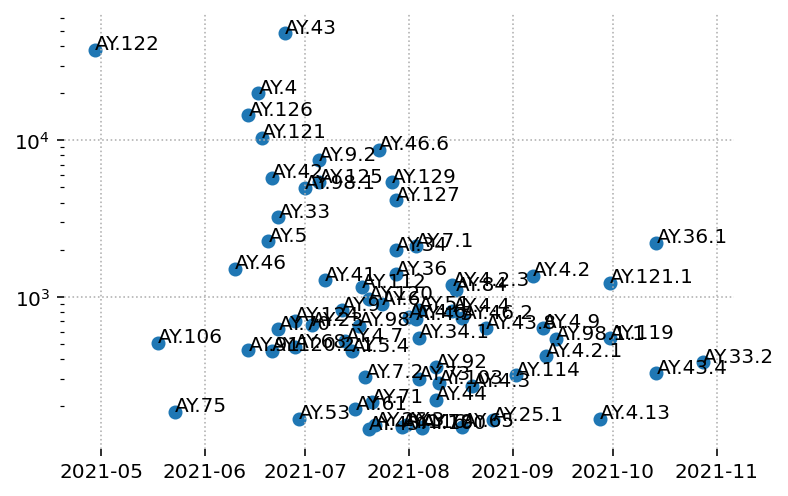

In [148]:
ay = bak.loc[bak.index.str.match('AY')]
plt.scatter(ay.date, ay.counts)
for i in ay.index:
    plt.text(bak.date[i], bak.counts[i], i)
plt.yscale('log')

In [150]:
vocs = ["B.1.1.529","BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.5.2","BA.2.12.1","BA.2.75", "BA.2.75.1","BA.2.75.2","BA.4.6", "BF.7", "BF.11", "BF.13", "BF.14","BQ.1","BQ.1.1"] + ["B.1.1.7","B.1.1.318","B.1.621","B.1.525","B.1.351","P.1","AY.43","AY.46.6","AY.4.2","AY.36.1"]

In [151]:
merged_lineages, G, _ = preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=100000)
merged_lineages

Dropped lineages []


['A',
 'B',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.1.529.5.3.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'XAB',
 'XAD',
 'XAF',
 'XAG',
 'XAH',
 'XAJ',
 'XAK',
 'XAL',
 'XAM',
 'XAN',
 'XAP',
 'XAS',
 'XAU',
 'XB',
 'XD',
 'XE',
 'XG',
 'XH',
 'XJ',
 'XM',
 'XV',
 'XW',
 'XZ']

In [152]:
G.sum((0,1))

array([6.93000e+02, 3.10940e+04, 9.77030e+04, 9.23000e+02, 1.17300e+03,
       1.52600e+03, 5.74510e+04, 1.09835e+05, 2.61243e+05, 3.92300e+03,
       9.00000e+01, 4.30000e+01, 2.90000e+01, 6.43500e+03, 7.16000e+02,
       7.40000e+04, 3.64620e+04, 1.91900e+03, 1.60000e+02, 4.60000e+01,
       8.60000e+01, 2.00000e+01, 1.20000e+01, 1.97900e+03, 8.60000e+02,
       1.75418e+05, 3.09900e+03, 2.22100e+03, 4.91790e+04, 8.70100e+03,
       1.65000e+02, 1.27000e+02, 9.00000e+01, 2.00000e+00, 5.00000e+00,
       5.00000e+00, 1.00000e+00, 1.27000e+02, 9.80000e+01, 6.00000e+00,
       2.80000e+01, 1.00000e+00, 1.00000e+00, 2.00000e+00, 5.00000e+00,
       1.00000e+00, 4.90000e+01, 4.60000e+01, 3.00000e+00, 1.00000e+00,
       3.79000e+02, 1.00000e+00, 5.30000e+01, 3.00000e+00])

In [153]:
baseline = 'B'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline and not x.startswith("X")] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['A',
 'B.1.1.7',
 'B.1.1.28.1',
 'B.1.1.318',
 'B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.1.529.5.2.1.14',
 'B.1.1.529.5.3.1.1.1.1.1',
 'B.1.1.529.5.3.1.1.1.1.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'B.1.617.2.4.2',
 'B.1.617.2.36.1',
 'B.1.617.2.43',
 'B.1.617.2.46.6',
 'B.1.621',
 'B']

In [154]:
merged_lineages_alias = [alias(x) for x in merged_lineages]
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'BQ.1',
 'BQ.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [155]:
dict(zip(merged_lineages_alias,G.sum((0,1))))

{'A': 693.0,
 'B.1.1.7': 97703.0,
 'P.1': 923.0,
 'B.1.1.318': 1173.0,
 'B.1.1.529': 1526.0,
 'BA.1': 57451.0,
 'BA.1.1': 109835.0,
 'BA.2': 261243.0,
 'BA.2.12.1': 3923.0,
 'BA.2.75': 90.0,
 'BA.2.75.1': 43.0,
 'BA.2.75.2': 29.0,
 'BA.4': 6435.0,
 'BA.4.6': 716.0,
 'BA.5': 74000.0,
 'BA.5.2': 36462.0,
 'BF.7': 1919.0,
 'BF.11': 160.0,
 'BF.13': 46.0,
 'BF.14': 86.0,
 'BQ.1': 20.0,
 'BQ.1.1': 12.0,
 'B.1.351': 1979.0,
 'B.1.525': 860.0,
 'B.1.617.2': 175418.0,
 'AY.4.2': 3099.0,
 'AY.36.1': 2221.0,
 'AY.43': 49179.0,
 'AY.46.6': 8701.0,
 'B.1.621': 165.0,
 'B': 31094.0}

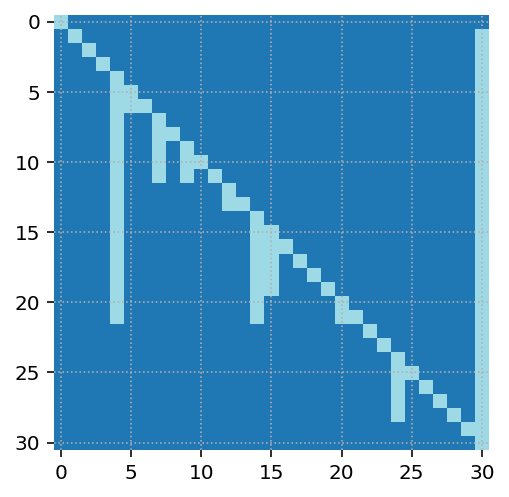

In [166]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

In [42]:
#A[1:-1,merged_lineages.index("B.1.1.7")] = 1
#A[merged_lineages.index('B.1.1.529'):-4,merged_lineages.index("B.1.617.2")] = 1
#plt.imshow(A)

### Cases
Also from RKI

In [43]:
cases_raw = pd.read_csv("https://github.com/robert-koch-institut/SARS-CoV-2-Infektionen_in_Deutschland/blob/main/Aktuell_Deutschland_SarsCov2_Infektionen.csv?raw=true",  index_col=[0,1,2,4], parse_dates=True)

In [44]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A80+         W          2022-10-03  2022-10-03   
            A35-A59      W          2022-10-03  2022-10-03   
            A15-A34      W          2022-10-03  2022-10-03   
            A60-A79      W          2022-10-03  2022-10-03   
            A15-A34      W          2022-10-04  2022-10-04   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A80+         W          2022-10-03                     0   
            A35-A59      W          2022-10-03                     0   
            A15-A34      W          2022-10-03                     0   
            A60-A79      W          2022-10-03                     0   
            A15-A34      W          2022-10-04                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A80+         W          2022-10-03          1              -9   
            A35-A59      W          2022-10-03          1              -9   
            A15-A34      W          2022-10-03          1              -9   
            A60-A79      W          2022-10-03          1              -9   
            A15-A34      W          2022-10-04          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A80+         W          2022-10-03          -9           3   
            A35-A59      W          2022-10-03          -9          11   
            A15-A34      W          2022-10-03          -9           3   
            A60-A79      W          2022-10-03          -9           7   
            A15-A34      W          2022-10-04          -9           2   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [45]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

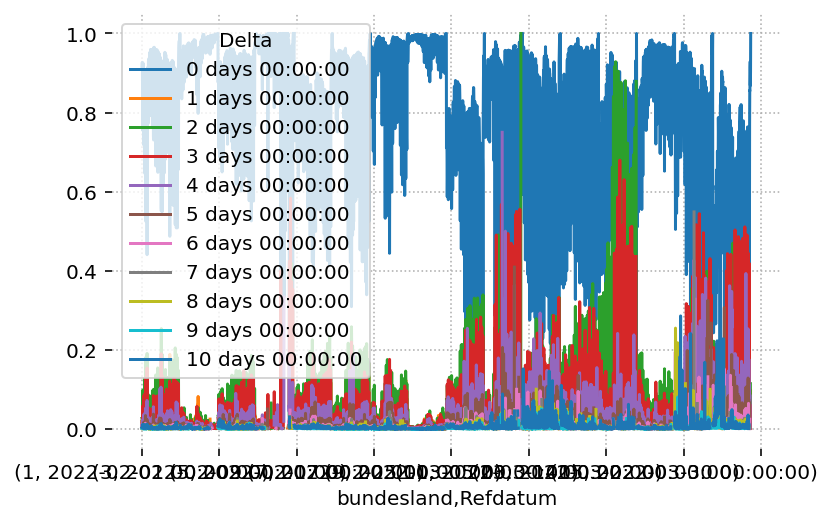

In [46]:
f.plot()

In [47]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [48]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [49]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.928539         0.949989         0.975473         0.988174   
Wed             0.925767         0.950014         0.975079         0.980540   
Thu             0.919877         0.945973         0.956255         0.962361   
Fri             0.911598         0.921921         0.934431         0.963595   
Sat             0.754186         0.777982         0.858471         0.940518   
Sun             0.663610         0.743619         0.871794         0.944577   
Mon             0.899544         0.926964         0.962888         0.981452   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.990676         0.991451         0.995692         0.997616   
Wed             0.982464         0.991511         0.995984         0.997697   
Thu             0.982673         0.992655         0.996211         0.997679   
Fri             0.984531         0.992655         0.995369         0.997023   
Sat             0.975953         0.986746         0.991786         0.992516   
Sun             0.972550         0.985062         0.985575         0.987456   
Mon             0.990418         0.992420         0.992954         0.995814   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.998437         0.998765               1.0  
Wed             0.998492         0.998971               1.0  
Thu             0.998308         0.998493               1.0  
Fri             0.997356         0.996412               1.0  
Sat             0.992453         0.995513               1.0  
Sun             0.992884         0.995036               1.0  
Mon             0.997356         0.998296               1.0

In [50]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [51]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [52]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999657  0.999638  0.999332  0.998512  0.997706   
Bayern                  0.992655  0.992096  0.986710  0.974495  0.949735   
Berlin                  0.987408  0.985133  0.980901  0.968452  0.946715   
Brandenburg             0.991590  0.992366  0.989987  0.981172  0.969947   
Bremen                  0.998365  0.998681  0.997866  0.993240  0.990604   
Hamburg                 0.997714  0.996948  0.996785  0.995632  0.992216   
Hessen                  0.998224  0.997858  0.996287  0.991764  0.987974   
Mecklenburg-Vorpommern  0.995776  0.996998  0.995418  0.990120  0.980767   
Niedersachsen           0.994631  0.995441  0.993558  0.989039  0.980106   
Nordrhein-Westfalen     0.994907  0.994058  0.990445  0.982012  0.967190   
Rheinland-Pfalz         0.997990  0.998634  0.997426  0.992732  0.990708   
Saarland                0.991749  0.995364  0.993738  0.984835  0.984094   
Sachsen                 0.998353  0.998645  0.997118  0.994107  0.986738   
Sachsen-Anhalt          0.984275  0.973997  0.975209  0.971813  0.930994   
Schleswig-Holstein      0.997356  0.997616  0.995984  0.992655  0.984531   
Thüringen               0.965731  0.964584  0.960750  0.932111  0.884405   

                               5         6         7         8  
Baden-Württemberg       0.990230  0.973668  0.990873  0.993043  
Bayern                  0.857680  0.714931  0.785753  0.794109  
Berlin                  0.785175  0.536086  0.882464  0.889641  
Brandenburg             0.871055  0.669691  0.918320  0.941146  
Bremen                  0.968374  0.807366  0.979943  0.986996  
Hamburg                 0.980121  0.969036  0.974419  0.974198  
Hessen                  0.948582  0.853970  0.935819  0.932433  
Mecklenburg-Vorpommern  0.875214  0.809038  0.762788  0.827773  
Niedersachsen           0.937625  0.844674  0.923176  0.938620  
Nordrhein-Westfalen     0.911686  0.804461  0.867000  0.858715  
Rheinland-Pfalz         0.948119  0.873345  0.966277  0.974103  
Saarland                0.804819  0.703233  0.857792  0.938403  
Sachsen                 0.955189  0.890255  0.942920  0.945357  
Sachsen-Anhalt          0.707361  0.571489  0.807034  0.857409  
Schleswig-Holstein      0.940518  0.871794  0.926964  0.928539  
Thüringen               0.746203  0.503960  0.688611  0.687017

In [53]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [54]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,start_date:,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-01-01  2021-01-02  2021-01-03  2021-01-04  \
bundesland                                                               
Baden-Württemberg           1586.0      1666.0      1663.0      2042.0   
Bayern                      2152.0      2446.0      2221.0      2911.0   
Berlin                       595.0       687.0       687.0      1006.0   
Brandenburg                  647.0       529.0       542.0      1097.0   
Bremen                        30.0        48.0        46.0        55.0   
Hamburg                      327.0       374.0       361.0       484.0   
Hessen                      1084.0       919.0       959.0      1174.0   
Mecklenburg-Vorpommern       178.0       218.0       271.0       485.0   
Niedersachsen                874.0       956.0       957.0      1287.0   
Nordrhein-Westfalen         2264.0      2600.0      2552.0      3695.0   
Rheinland-Pfalz              541.0       680.0       480.0       712.0   
Saarland                     144.0       116.0       154.0       233.0   
Sachsen                     1371.0      1489.0      1447.0      2031.0   
Sachsen-Anhalt               691.0       651.0       600.0       782.0   
Schleswig-Holstein           298.0       346.0       318.0       371.0   
Thüringen                    615.0       702.0       805.0       923.0   

Refdatum                2021-01-05  2021-01-06  2021-01-07  2021-01-08  \
bundesland                                                               
Baden-Württemberg           2554.0      1964.0      2065.0      2250.0   
Bayern                      3603.0      3026.0      3271.0      3585.0   
Berlin                       981.0      1008.0       992.0       986.0   
Brandenburg                 1196.0      1092.0      1055.0       907.0   
Bremen                        81.0        96.0       102.0        81.0   
Hamburg                      425.0       379.0       392.0       341.0   
Hessen                      1533.0      1719.0      1409.0      1361.0   
Mecklenburg-Vorpommern       269.0       295.0       221.0       255.0   
Niedersachsen               1505.0      1649.0      1300.0      1312.0   
Nordrhein-Westfalen         3985.0      4428.0      3815.0      3699.0   
Rheinland-Pfalz              843.0       923.0      1015.0       903.0   
Saarland                     242.0       316.0       284.0       241.0   
Sachsen                     2507.0      2389.0      2056.0      1994.0   
Sachsen-Anhalt               802.0       700.0       955.0       866.0   
Schleswig-Holstein           413.0       396.0       392.0       414.0   
Thüringen                   1017.0       922.0       887.0      1070.0   

Refdatum                2021-01-09  2021-01-10  ...  2022-09-25  2022-09-26  \
bundesland                                      ...                           
Baden-Württemberg           1800.0      1381.0  ...       951.0      9790.0   
Bayern                      2642.0      1929.0  ...      4670.0     15761.0   
Berlin                       554.0       461.0  ...       177.0      2190.0   
Brandenburg                  752.0       651.0  ...       270.0      2290.0   
Bremen                        83.0        43.0  ...        17.0       762.0   
Hamburg                      237.0       294.0  ...       364.0       701.0   
Hessen                      1132.0       782.0  ...      1058.0      7765.0   
Mecklenburg-Vorpommern       192.0       289.0  ...       374.0      1601.0   
Niedersachsen               1189.0       731.0  ...      1010.0      7125.0   
Nordrhein-Westfalen         2760.0      2163.0  ...      3840.0     12347.0   
Rheinland-Pfalz              662.0       419.0  ...       430.0      5754.0   
Saarland                     228.0       104.0  ...        67.0      1546.0   
Sachsen                     1235.0       881.0  ...       432.0      3908.0   
Sachsen-Anhalt               536.0       505.0  ...       408.0      1730.0   
Schleswig-Holstein           378.0       294.0  ...       576.0      2

In [55]:
cases_land.sum(0)

Refdatum
2021-01-01    13397.0
2021-01-02    14427.0
2021-01-03    14063.0
2021-01-04    19288.0
2021-01-05    21956.0
               ...   
2022-09-30    63912.0
2022-10-01    15483.0
2022-10-02     7519.0
2022-10-03     8383.0
2022-10-04    71411.0
Length: 642, dtype: float64

In [56]:
clip = 2
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

Refdatum                2021-01-01  2021-01-02  2021-01-03  2021-01-04  \
bundesland                                                               
Baden-Württemberg           1586.0      1666.0      1663.0      2042.0   
Bayern                      2152.0      2446.0      2221.0      2911.0   
Berlin                       595.0       687.0       687.0      1006.0   
Brandenburg                  647.0       529.0       542.0      1097.0   
Bremen                        30.0        48.0        46.0        55.0   
Hamburg                      327.0       374.0       361.0       484.0   
Hessen                      1084.0       919.0       959.0      1174.0   
Mecklenburg-Vorpommern       178.0       218.0       271.0       485.0   
Niedersachsen                874.0       956.0       957.0      1287.0   
Nordrhein-Westfalen         2264.0      2600.0      2552.0      3695.0   
Rheinland-Pfalz              541.0       680.0       480.0       712.0   
Saarland                     144.0       116.0       154.0       233.0   
Sachsen                     1371.0      1489.0      1447.0      2031.0   
Sachsen-Anhalt               691.0       651.0       600.0       782.0   
Schleswig-Holstein           298.0       346.0       318.0       371.0   
Thüringen                    615.0       702.0       805.0       923.0   

Refdatum                2021-01-05  2021-01-06  2021-01-07  2021-01-08  \
bundesland                                                               
Baden-Württemberg           2554.0      1964.0      2065.0      2250.0   
Bayern                      3603.0      3026.0      3271.0      3585.0   
Berlin                       981.0      1008.0       992.0       986.0   
Brandenburg                 1196.0      1092.0      1055.0       907.0   
Bremen                        81.0        96.0       102.0        81.0   
Hamburg                      425.0       379.0       392.0       341.0   
Hessen                      1533.0      1719.0      1409.0      1361.0   
Mecklenburg-Vorpommern       269.0       295.0       221.0       255.0   
Niedersachsen               1505.0      1649.0      1300.0      1312.0   
Nordrhein-Westfalen         3985.0      4428.0      3815.0      3699.0   
Rheinland-Pfalz              843.0       923.0      1015.0       903.0   
Saarland                     242.0       316.0       284.0       241.0   
Sachsen                     2507.0      2389.0      2056.0      1994.0   
Sachsen-Anhalt               802.0       700.0       955.0       866.0   
Schleswig-Holstein           413.0       396.0       392.0       414.0   
Thüringen                   1017.0       922.0       887.0      1070.0   

Refdatum                2021-01-09  2021-01-10  ...  2022-09-23  2022-09-24  \
bundesland                                      ...                           
Baden-Württemberg           1800.0      1381.0  ...      5469.0      1614.0   
Bayern                      2642.0      1929.0  ...      9511.0      5895.0   
Berlin                       554.0       461.0  ...      1319.0       256.0   
Brandenburg                  752.0       651.0  ...      1518.0       297.0   
Bremen                        83.0        43.0  ...       266.0       113.0   
Hamburg                      237.0       294.0  ...       656.0       287.0   
Hessen                      1132.0       782.0  ...      4875.0      1630.0   
Mecklenburg-Vorpommern       192.0       289.0  ...       825.0       197.0   
Niedersachsen               1189.0       731.0  ...      5152.0      1633.0   
Nordrhein-Westfalen         2760.0      2163.0  ...      8382.0      4293.0   
Rheinland-Pfalz              662.0       419.0  ...      3000.0       437.0   
Saarland                     228.0       104.0  ...       864.0         5.0   
Sachsen                     1235.0       881.0  ...      2185.0       903.0   
Sachsen-Anhalt               536.0       505.0  ...      1050.0       551.0   
Schleswig-Holstein           378.0       294.0  ...      1560.0       

In [57]:
C = cases_land.values

### Population data
From Destatis

In [58]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [59]:
131 % 10

1

## Modeling
### Basis functions

In [60]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip 
inc = 10
B0 = fused_basis(n+2, inc=inc, fuse=5, pad=35 - n % inc) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])
#B0 = B0[:,:-(inc-n%inc)][:,-n:]

In [61]:
B0.shape

(2, 642, 67)

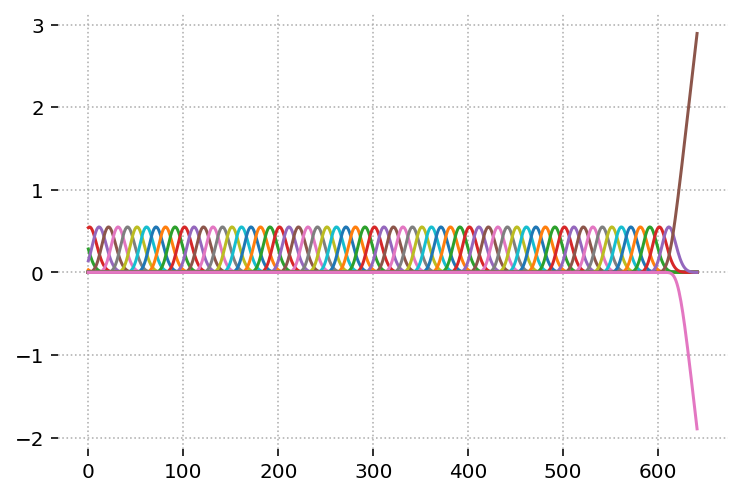

In [62]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

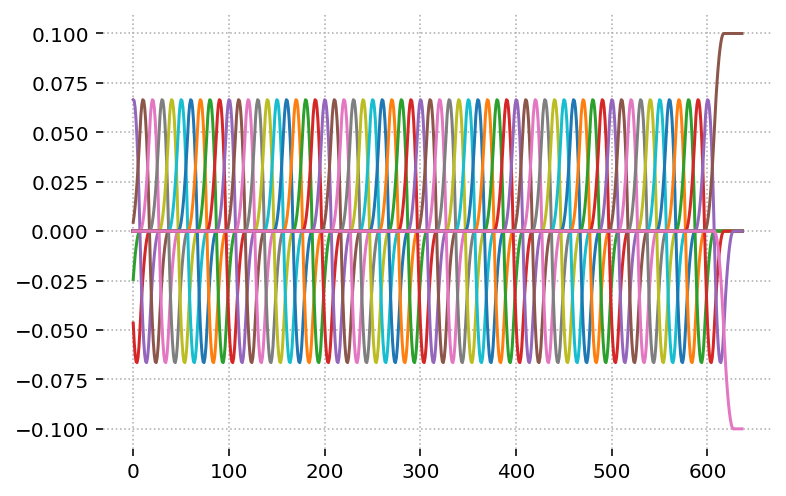

In [63]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [64]:
np.sum(np.diff(B0[1,-30:,-1])+1 == 1)

14

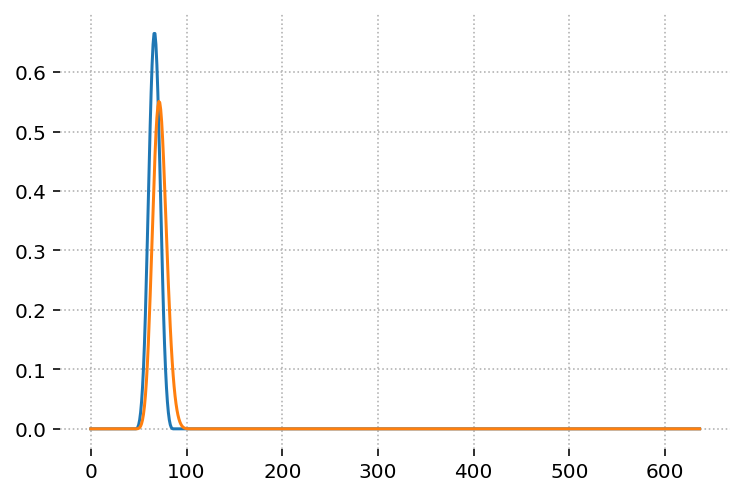

In [65]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


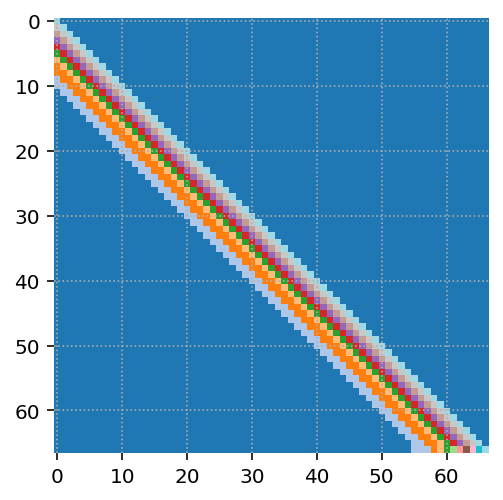

In [66]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.75
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [156]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [157]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [158]:
from numpyro.infer import Trace_ELBO

In [159]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [160]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..
#GG[-1, genomes.index.levels[1] <= "2022-07-15", merged_lineages_alias.index("BA.2.75")] = 0
GG[:, genomes.index.levels[1] < "2022-02-01", merged_lineages_alias.index("BA.5")] = 0 # Some erroneous BA.5
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.1.7")] = 0 # Issues with spurious B lineages later on
GG[:, genomes.index.levels[1] >= "2021-11-01", merged_lineages_alias.index("B.1.351")] = 0 # Issues with spurious B lineages later on
GG[:, (genomes.index.levels[1] < "2021-11-01").reshape(-1,1) * np.array([x.startswith("B.1.1.529") for x in merged_lineages]).reshape(1,-1)] = 0
GG[:, (genomes.index.levels[1] < "2021-04-01").reshape(-1,1) * np.array([x.startswith("B.1.617.2") for x in merged_lineages]).reshape(1,-1)] = 0

In [161]:
GG[:, genomes.index.levels[1] <= "2021-04-01"][:,:,[x.startswith("B.1.617.2") for x in merged_lineages]].sum()

0.0

In [162]:
x = (GG[-1].cumsum(0)>0).argmax(0)
dict(zip(merged_lineages, x))

{'A': 5,
 'B.1.1.7': 1,
 'B.1.1.28.1': 33,
 'B.1.1.318': 20,
 'B.1.1.529': 348,
 'B.1.1.529.1': 326,
 'B.1.1.529.1.1': 320,
 'B.1.1.529.2': 336,
 'B.1.1.529.2.12.1': 458,
 'B.1.1.529.2.75': 518,
 'B.1.1.529.2.75.1': 541,
 'B.1.1.529.2.75.2': 579,
 'B.1.1.529.4': 415,
 'B.1.1.529.4.6': 489,
 'B.1.1.529.5': 429,
 'B.1.1.529.5.2': 419,
 'B.1.1.529.5.2.1.7': 528,
 'B.1.1.529.5.2.1.11': 543,
 'B.1.1.529.5.2.1.13': 572,
 'B.1.1.529.5.2.1.14': 553,
 'B.1.1.529.5.3.1.1.1.1.1': 599,
 'B.1.1.529.5.3.1.1.1.1.1.1': 600,
 'B.1.351': 4,
 'B.1.525': 17,
 'B.1.617.2': 94,
 'B.1.617.2.4.2': 186,
 'B.1.617.2.36.1': 276,
 'B.1.617.2.43': 170,
 'B.1.617.2.46.6': 189,
 'B.1.621': 98,
 'B': 0}

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [167]:
model = MultiLineageTimeShift(
    CC[[-1]],
    GG[[-1]],    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    #b_scale=0.01,
    b0_scale=0.3,
    #c_scale=30,
    c0_scale=5,
    c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    week=True,
    fit_logits=False,#True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.03, 'lrd': 0.5 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [168]:
model.fit(num_epochs=200)

SVI step 0 / 200 | 0 %


(0.0, 1000000.0)

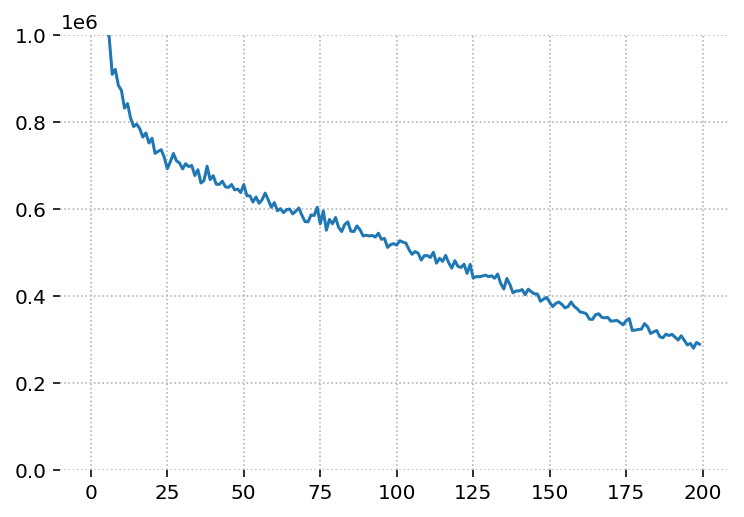

In [169]:
plt.plot(model.loss)
plt.ylim((0,1e6))

In [170]:
model.fit(num_epochs=400)

SVI step 0 / 400 | 0 %
SVI step 200 / 400 | 50 %


Text(0, 0.5, 'ELBO')

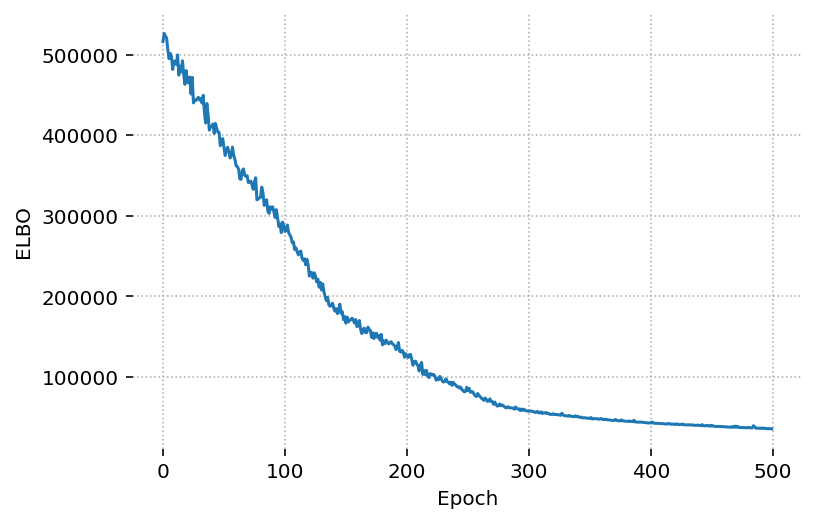

In [171]:
plt.plot(model.loss[100:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [172]:
model.fit(num_epochs=2000)

SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

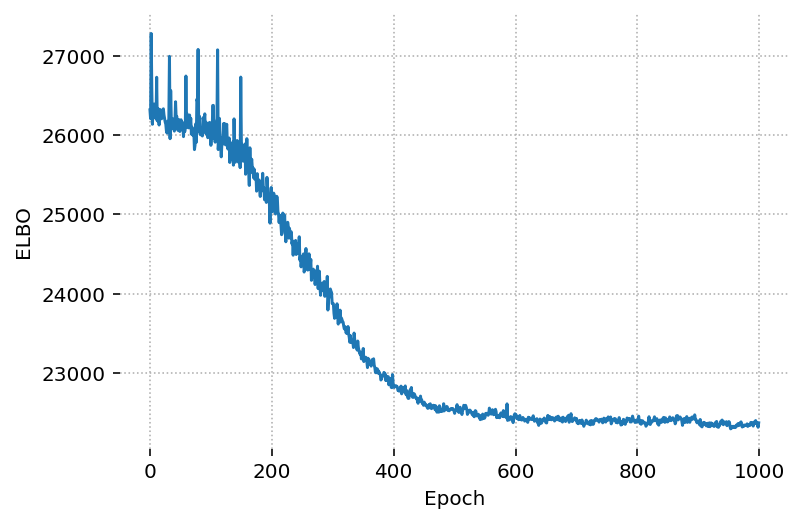

In [173]:
plt.plot(model.loss[-1000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

In [174]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'rebeccapurple',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"C6",
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"C3",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  'BA.5.2': 'darkcyan',
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                  'BF.14':'green',
                   'BQ.1':'aquamarine',
                  'BQ.1.1':'mediumspringgreen',
                 #'Other':"C7",
                 'B.1.617.2': 'C0',
                 'AY.4.2': 'lightblue',
                  'AY.36.1': 'steelblue',
                  'AY.43': 'skyblue',
                  'AY.46.6': 'lightsteelblue',
                  'A': 'lightgrey',
                  'B': 'lightgrey',
                  'B.1.1.7': 'navy' ,
                  'B.1.351': 'black',
                  'P.1' : 'slategrey',
                  'B.1.525':'C7',
                  'B.1.1.318': 'grey',
                  'B.1.621':'grey'
                 } #"aliceblue"}

In [175]:
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'BQ.1',
 'BQ.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [176]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

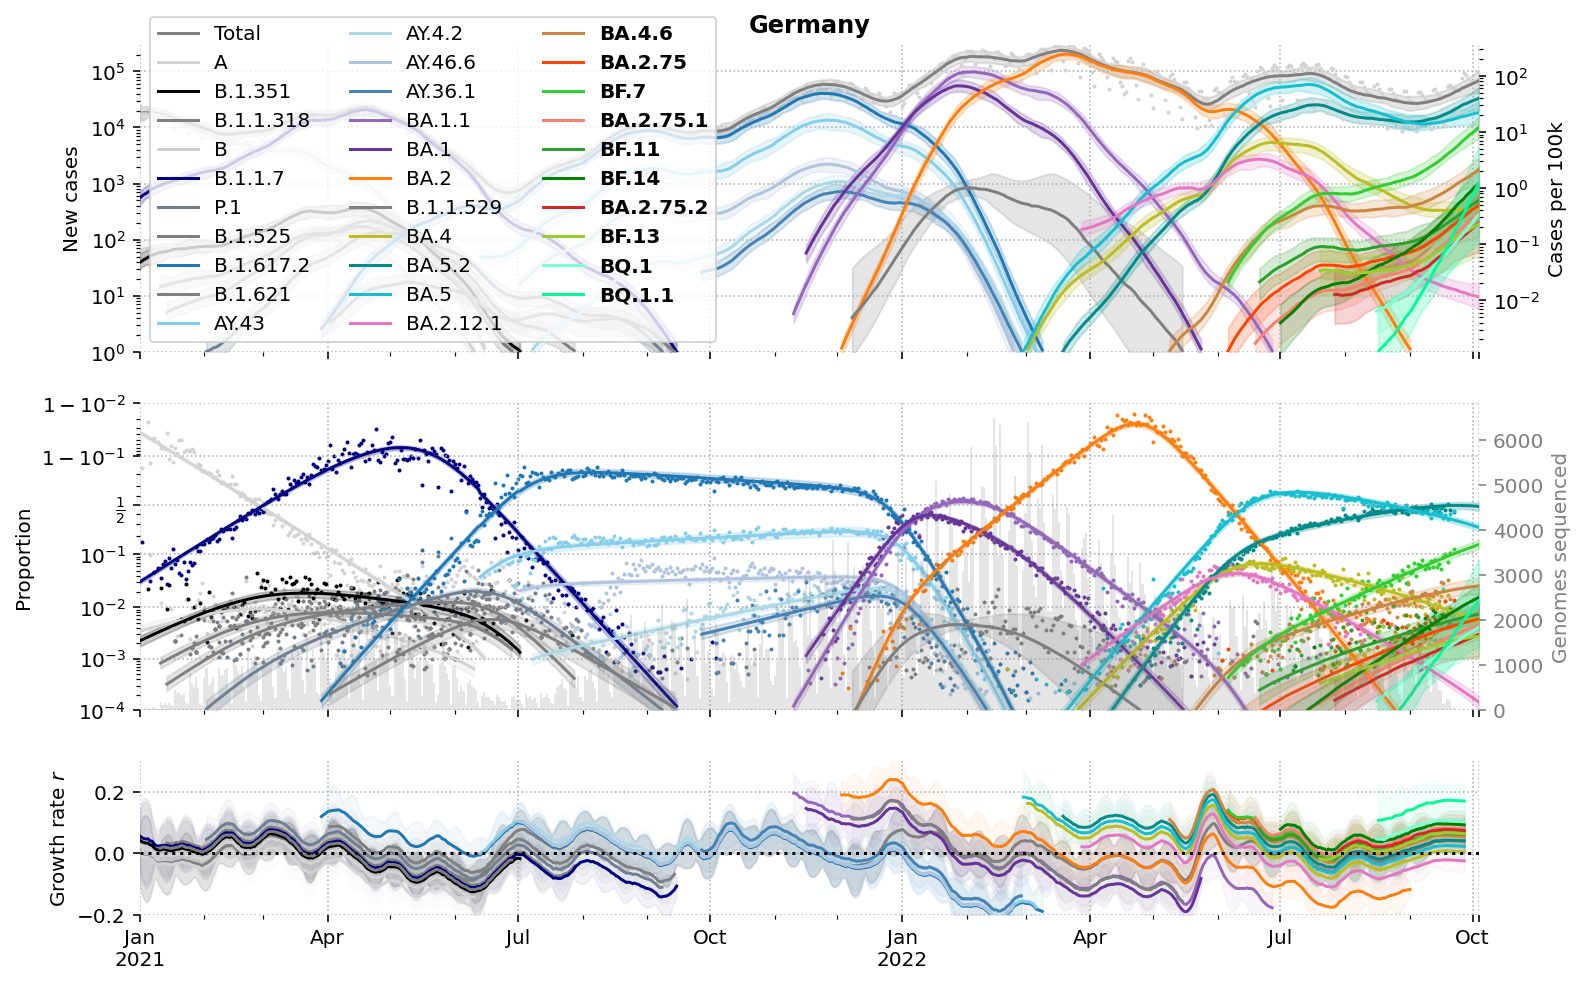

In [177]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
x = (GG[-1].cumsum(0)>0).argmax(0)
o = np.argsort(x + np.argsort(merged_lineages))
for i,r in [(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = o#np.where(GG[i].sum(0) >= 3)[0]
    #w = list(set(w) - set([0,GG.shape[2]-2]))
    #w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date=start_date, show_start_date=start_date,
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(12,8),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    #ax[2].set_xlim(("2022-06-01",None))
    #ax[0].legend("off")
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=3)
    for l in leg.get_texts():
        if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ"]),l.get_text()):
            l.set_weight('bold')
    #plt.gcf().set_size_inches(12,12)

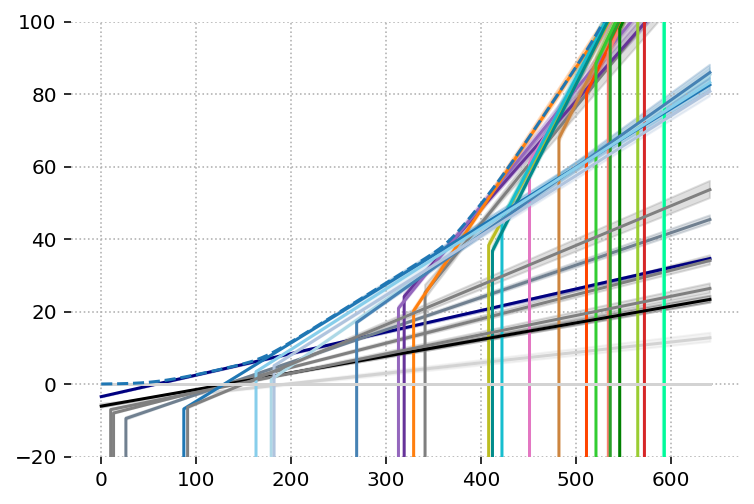

In [178]:
l = model.get_logits(ltla=-1).squeeze()
#l -= logsumexp(l.mean(0),-1)[...,np.newaxis]
#m = 0.5 * (((r-r[0])/x)[:-1].mean()) * np.arange(l.shape[1])**2 + r[1]*np.arange(l.shape[1]) - 15#np.max(np.mean(l,0),-1)
for i in range(l.shape[-1]):
    plt.plot(np.median(l[...,i],0), c=lineage_colors[merged_lineages_alias[i]])
    plt.fill_between(x=np.arange(l.shape[1]), y1=np.quantile(l[...,i],0.05, 0), y2=np.quantile(l[...,i],0.95, 0), color=lineage_colors[merged_lineages_alias[i]], alpha=0.25)
plt.ylim((-20,100))
#l.shape
#plt.plot(seq_index, 0.5 * 0.0008 * seq_index**2)

from scipy.special import logsumexp
plt.plot(logsumexp(l.mean(0).squeeze(), -1), ls="--")


#plt.plot(np.max(np.mean(l,0),-1))

In [179]:
lse = logsumexp(l.mean(0).squeeze(), -1)
t0 = 100
y =lse[-t0:] - (lse[-t0]-lse[-t0-1])*np.arange(t0) - lse[-t0]
#plt.plot(np.diff(y))
#plt.plot(l.mean(0).squeeze().max(-1))

In [180]:
b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=["Germany"])# cases_land.index.to_list() + ["Germany"])

In [181]:
r

A  B.1.1.7       P.1  B.1.1.318  B.1.1.529      BA.1    BA.1.1  \
Germany -0.0304      0.0  0.030022   0.007802   0.263245  0.239474  0.264347   

             BA.2  BA.2.12.1   BA.2.75  ...    BQ.1.1   B.1.351   B.1.525  \
Germany  0.333516   0.399354  0.492293  ...  0.586918 -0.013247 -0.006402   

         B.1.617.2    AY.4.2  AY.36.1    AY.43   AY.46.6   B.1.621        B  
Germany    0.10231  0.122975  0.12639  0.10772  0.105863  0.049599 -0.05935  

[1 rows x 31 columns]

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(1, 0, 'A'),
  Text(2, 0, 'B.1.1.7'),
  Text(3, 0, 'P.1'),
  Text(4, 0, 'B.1.1.318'),
  Text(5, 0, 'B.1.1.529'),
  Text(6, 0, 'BA.1'),
  Text(7, 0, 'BA.1.1'),
  Text(8, 0, 'BA.2'),
  Text(9, 0, 'BA.2.12.1'),
  Text(10, 0, 'BA.2.75'),
  Text(11, 0, 'BA.2.75.1'),
  Text(12, 0, 'BA.2.75.2'),
  Text(13, 0, 'BA.4'),
  Text(14, 0, 'BA.4.6'),
  Text(15, 0, 'BA.5'),
  Text(16, 0, 'BA.5.2'),
  Text(17, 0, 'BF.7'),
  Text(18, 0, 'BF.11'),
  Text(19, 0, 'BF.13'),
  Text(20, 0, 'BF.14'),
  Text(21, 0, 'BQ.1'),
  Text(22, 0, 'BQ.1.1'),
  Text(23, 0, 'B.1.351'),
  Text(24, 0, 'B.1.525'),
  Text(25, 0, 'B.1.617.2'),
  Text(26, 0, 'AY.4.2'),
  Text(27, 0, 'AY.36.1'),
  Text(28, 0, 'AY.43'),
  Text(29, 0, 'AY.46.6'),
  Text(30, 0, 'B.1.621'),
  Text(31, 0, 'B')])

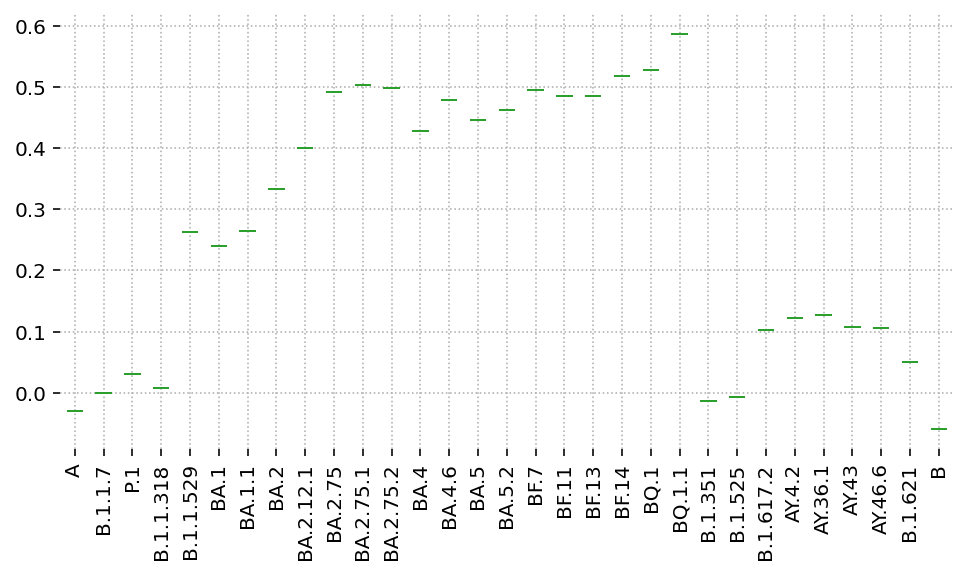

In [182]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


In [183]:
import re

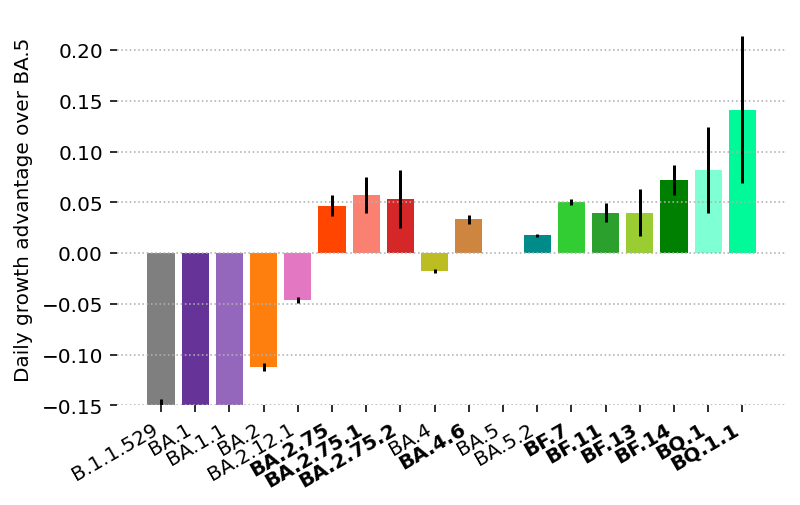

[Text(0, 0, 'B.1.1.529'), Text(1, 0, 'BA.1'), Text(2, 0, 'BA.1.1'), Text(3, 0, 'BA.2'), Text(4, 0, 'BA.2.12.1'), Text(5, 0, 'BA.2.75'), Text(6, 0, 'BA.2.75.1'), Text(7, 0, 'BA.2.75.2'), Text(8, 0, 'BA.4'), Text(9, 0, 'BA.4.6'), Text(10, 0, 'BA.5'), Text(11, 0, 'BA.5.2'), Text(12, 0, 'BF.7'), Text(13, 0, 'BF.11'), Text(14, 0, 'BF.13'), Text(15, 0, 'BF.14'), Text(16, 0, 'BQ.1'), Text(17, 0, 'BQ.1.1')]


In [216]:
baseline = "BA.5"
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).mean((2))[:,-1], columns=merged_lineages_alias)[[x for x in merged_lineages_alias if alias(x, anti_alias=True).startswith("B.1.1.529")]]
#s.boxplot()
plt.figure(figsize=(6,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.std(), color=[lineage_colors[x] for x in s.columns])
#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ.1"]),l.get_text()):
        l.set_weight('bold')
plt.show()
print(xl)

In [217]:
q=(0.025,0.5,0.975)
pd.DataFrame(np.quantile(model.get_probabilities()[:,0,-1:,:], q, 0).squeeze(), index=np.array(q), columns=merged_lineages_alias).T

0.025         0.500         0.975
A          0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.7    0.000000e+00  0.000000e+00  0.000000e+00
P.1        0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.318  0.000000e+00  0.000000e+00  0.000000e+00
B.1.1.529  2.155915e-19  8.124126e-16  4.083651e-12
BA.1       4.735193e-17  1.174884e-16  2.454406e-16
BA.1.1     4.689579e-14  9.449409e-14  1.695767e-13
BA.2       3.759564e-07  6.337777e-07  9.497001e-07
BA.2.12.1  1.056520e-04  1.417072e-04  1.879639e-04
BA.2.75    3.745789e-03  5.993092e-03  1.113821e-02
BA.2.75.1  2.343658e-03  4.469172e-03  1.054725e-02
BA.2.75.2  1.117053e-03  2.954263e-03  8.912728e-03
BA.4       3.938148e-03  5.182468e-03  6.541024e-03
BA.4.6     1.775791e-02  2.581755e-02  3.658353e-02
BA.5       2.394909e-01  2.692142e-01  3.004431e-01
BA.5.2     4.368515e-01  4.849650e-01  5.244496e-01
BF.7       1.223462e-01  1.457685e-01  1.742390e-01
BF.11      4.808103e-03  7.342846e-03  1.207042e-02
BF.13      1.041808e-03  2.732344e-03  7.451286e-03
BF.14      8.150842e-03  1.559907e-02  2.783460e-02
BQ.1       1.273728e-03  4.127810e-03  1.800850e-02
BQ.1.1     1.737210e-03  1.321687e-02  8.026956e-02
B.1.351    0.000000e+00  0.000000e+00  0.000000e+00
B.1.525    0.000000e+00  0.000000e+00  0.000000e+00
B.1.617.2  8.275154e-34  4.932860e-33  2.760508e-32
AY.4.2     1.454457e-32  7.913896e-32  4.246503e-31
AY.36.1    2.571893e-32  1.473211e-31  8.080544e-31
AY.43      1.438405e-33  8.840465e-33  4.391286e-32
AY.46.6    1.477719e-34  8.149332e-34  4.408925e-33
B.1.621    0.000000e+00  1.401298e-45  1.895256e-44
B          0.000000e+00  0.000000e+00  0.000000e+00

In [218]:
model.posterior['b1'].mean(0)[-1,0,:]

array([0.02894994, 0.05934983, 0.08937215, 0.06715199, 0.3225945 ,
       0.2988242 , 0.32369733, 0.3928659 , 0.45870376, 0.5516427 ,
       0.5621208 , 0.558214  , 0.48736614, 0.538075  , 0.50473696,
       0.522329  , 0.5550377 , 0.54469496, 0.5447698 , 0.57670134,
       0.58652365, 0.64626855, 0.04610242, 0.05294754, 0.16166008,
       0.1823249 , 0.18574029, 0.16706942, 0.16521326, 0.10894908,
       0.        ], dtype=float32)

In [219]:
f = model.params['bc0_loc'].reshape(2,-1)[0,:]/100
f = np.append(f, -A[-1,:-1] @ f / A[-1,-1])
A @ f

array([0.02889882, 0.05940374, 0.08945909, 0.06701705, 0.32167283,
       0.29920935, 0.32409008, 0.39313761, 0.4587672 , 0.5514149 ,
       0.56254142, 0.56018204, 0.4872179 , 0.53778097, 0.50454369,
       0.52217527, 0.55491848, 0.54400974, 0.54635612, 0.57622614,
       0.58521909, 0.64518988, 0.04611119, 0.05294307, 0.16169342,
       0.1825217 , 0.18587039, 0.16710275, 0.16513518, 0.10925326,
       0.        ])

In [220]:
pd.Series(np.diff(model.get_logits().mean(0)[-1,-2:,:], axis=0)[0], index=merged_lineages)

A                            0.028951
B.1.1.7                      0.059353
B.1.1.28.1                   0.089375
B.1.1.318                    0.067150
B.1.1.529                    0.322594
B.1.1.529.1                  0.298836
B.1.1.529.1.1                0.323715
B.1.1.529.2                  0.392868
B.1.1.529.2.12.1             0.458710
B.1.1.529.2.75               0.551651
B.1.1.529.2.75.1             0.562119
B.1.1.529.2.75.2             0.558212
B.1.1.529.4                  0.487366
B.1.1.529.4.6                0.538071
B.1.1.529.5                  0.504730
B.1.1.529.5.2                0.522324
B.1.1.529.5.2.1.7            0.555023
B.1.1.529.5.2.1.11           0.544693
B.1.1.529.5.2.1.13           0.544785
B.1.1.529.5.2.1.14           0.576691
B.1.1.529.5.3.1.1.1.1.1      0.586548
B.1.1.529.5.3.1.1.1.1.1.1    0.646255
B.1.351                      0.046103
B.1.525                      0.052952
B.1.617.2                    0.161659
B.1.617.2.4.2                0.182327
B.1.617.2.36

In [221]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0

In [222]:
model.posterior.keys()

dict_keys(['b1', 'bc0', 'beta1', 'c1', 't', 'b0'])

In [223]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [224]:
λ.shape

(1, 642, 31)

In [225]:
λ[-1,-1]/λ[-1,-1].sum()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.11172870e-16, 1.15729551e-16, 9.19956464e-14, 5.88208844e-07,
       1.41284513e-04, 6.14471563e-03, 4.50107433e-03, 2.97106742e-03,
       5.14901647e-03, 2.65564814e-02, 2.70519240e-01, 4.91705992e-01,
       1.47733976e-01, 7.49281141e-03, 2.80965060e-03, 1.49714782e-02,
       4.11517550e-03, 1.51874487e-02, 0.00000000e+00, 0.00000000e+00,
       4.73361847e-33, 6.98447185e-32, 1.56746535e-31, 8.17670429e-33,
       7.92459748e-34, 1.27393733e-45, 0.00000000e+00])

In [226]:
merged_lineages_alias

['A',
 'B.1.1.7',
 'P.1',
 'B.1.1.318',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2',
 'BF.7',
 'BF.11',
 'BF.13',
 'BF.14',
 'BQ.1',
 'BQ.1.1',
 'B.1.351',
 'B.1.525',
 'B.1.617.2',
 'AY.4.2',
 'AY.36.1',
 'AY.43',
 'AY.46.6',
 'B.1.621',
 'B']

In [227]:
λ[-1,-1] / λ[-1,-1].sum()

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       9.11172870e-16, 1.15729551e-16, 9.19956464e-14, 5.88208844e-07,
       1.41284513e-04, 6.14471563e-03, 4.50107433e-03, 2.97106742e-03,
       5.14901647e-03, 2.65564814e-02, 2.70519240e-01, 4.91705992e-01,
       1.47733976e-01, 7.49281141e-03, 2.80965060e-03, 1.49714782e-02,
       4.11517550e-03, 1.51874487e-02, 0.00000000e+00, 0.00000000e+00,
       4.73361847e-33, 6.98447185e-32, 1.56746535e-31, 8.17670429e-33,
       7.92459748e-34, 1.27393733e-45, 0.00000000e+00])

In [228]:
from genomicsurveillance.misc import get_transmissibility

In [229]:
GG.shape

(17, 629, 31)

In [230]:
d = model.posterior['bc0'].mean(0).squeeze()[:GG.shape[-1]-1]

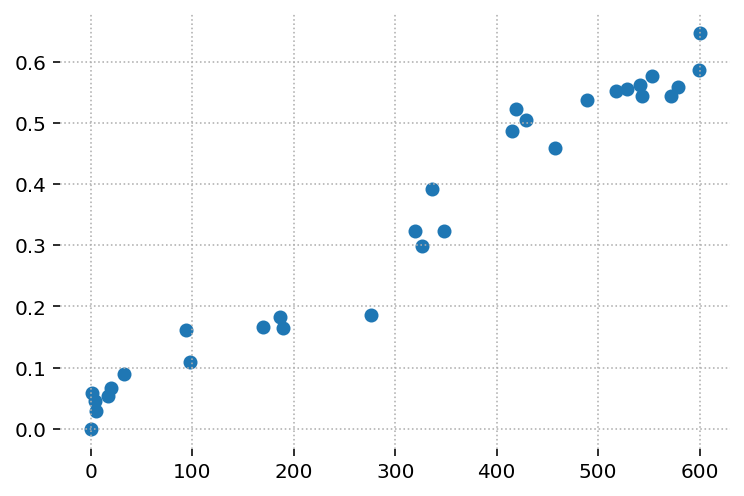

In [231]:
x = (GG[-1].cumsum(0)>0).argmax(0)
r = b.squeeze().mean(0)
plt.scatter(x, r)

In [232]:
x = (GG[-1].cumsum(0)>0).argmax(0)
y = (-GG[-1]).cumsum(0).argmin(0)
dict(zip(merged_lineages_alias, genomes.index.levels[1][y]))

{'A': Timestamp('2021-06-21 00:00:00'),
 'B.1.1.7': Timestamp('2021-10-04 00:00:00'),
 'P.1': Timestamp('2021-10-22 00:00:00'),
 'B.1.1.318': Timestamp('2022-03-24 00:00:00'),
 'B.1.1.529': Timestamp('2022-06-30 00:00:00'),
 'BA.1': Timestamp('2022-09-09 00:00:00'),
 'BA.1.1': Timestamp('2022-07-21 00:00:00'),
 'BA.2': Timestamp('2022-09-20 00:00:00'),
 'BA.2.12.1': Timestamp('2022-09-06 00:00:00'),
 'BA.2.75': Timestamp('2022-09-22 00:00:00'),
 'BA.2.75.1': Timestamp('2022-09-18 00:00:00'),
 'BA.2.75.2': Timestamp('2022-09-20 00:00:00'),
 'BA.4': Timestamp('2022-09-20 00:00:00'),
 'BA.4.6': Timestamp('2022-09-20 00:00:00'),
 'BA.5': Timestamp('2022-09-22 00:00:00'),
 'BA.5.2': Timestamp('2022-09-22 00:00:00'),
 'BF.7': Timestamp('2022-09-22 00:00:00'),
 'BF.11': Timestamp('2022-09-20 00:00:00'),
 'BF.13': Timestamp('2022-09-14 00:00:00'),
 'BF.14': Timestamp('2022-09-20 00:00:00'),
 'BQ.1': Timestamp('2022-09-15 00:00:00'),
 'BQ.1.1': Timestamp('2022-09-19 00:00:00'),
 'B.1.351': Time

In [277]:
tt = np.concatenate([t, t[0,-1,:] + np.arange(70).reshape((1,-1,1))], axis=1)
gg = np.concatenate([g, g[0,-1,:] + np.repeat(0,70).reshape((1,-1,1))], axis=1)

In [298]:
(np.arange(70).reshape((1,1,-1,1)) * model.posterior['b1']).shape

(100, 1, 70, 31)

In [299]:
ll.shape

(100, 1, 642, 31)

In [300]:
(ll[:,:,[-1],:] + np.arange(70).reshape((1,1,-1,1)) * model.posterior['b1']).shape

(100, 1, 70, 31)

In [301]:
ll = model.get_logits()
ll = np.concatenate([ll, ll[:,:,[-1],:] + np.arange(70).reshape((1,1,-1,1)) * model.posterior['b1']], axis=2)

In [303]:
from scipy.special import softmax
pp = softmax(ll, axis=-1)

In [304]:
f = np.einsum("...l,...l", pp, b).squeeze()

In [305]:
r = b.squeeze()
from adjustText import adjust_text

In [235]:
r.shape

(100, 31)

In [236]:
f.shape

(100, 642)

In [237]:
r0 = model.get_growth_rate().squeeze()

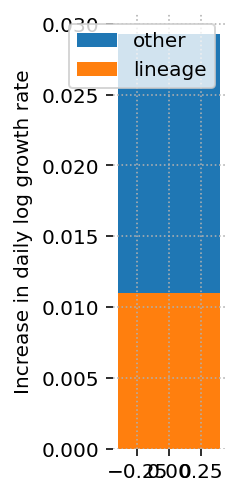

In [238]:
plt.figure(figsize=(1,4))
plt.bar(x=0,height=(r0[:,-1]-r0[:,-29]).mean(0), bottom=(f[:,-1]-f[:,-29]).mean(0), label='other') 
plt.bar(x=0 , height=(f[:,-1]-f[:,-29]).mean(0), label='lineage')
plt.ylabel("Increase in daily log growth rate")
plt.legend()

In [239]:
 cases_land.columns

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2022-09-23', '2022-09-24', '2022-09-25', '2022-09-26',
               '2022-09-27', '2022-09-28', '2022-09-29', '2022-09-30',
               '2022-10-01', '2022-10-02'],
              dtype='datetime64[ns]', name='Refdatum', length=640, freq=None)

In [306]:
f.shape

(100, 712)

In [308]:
import matplotlib.pyplot as plt

In [311]:
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/matplotlib/pyplot.py'>

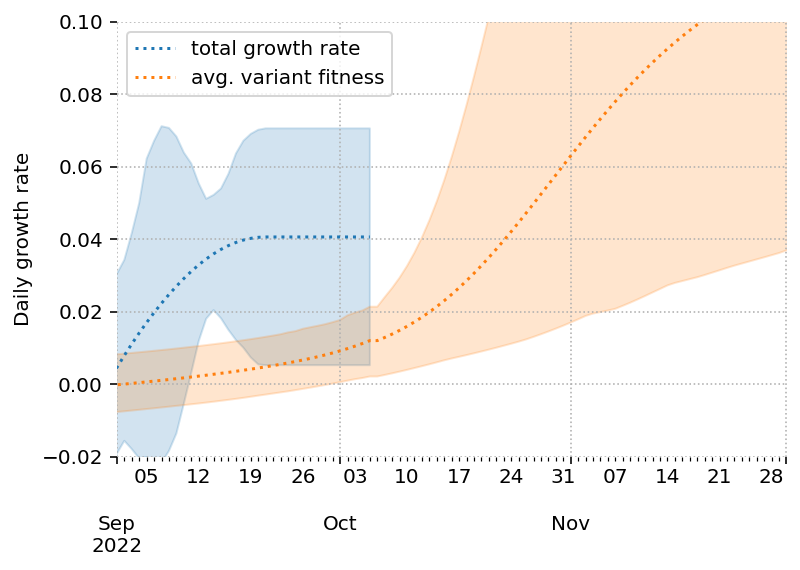

In [314]:
#plt.figure(figsize=(1,4))
pd.Series(np.nan, index=pd.date_range("2022-01-01","2022-07-01")).plot(label="", figsize=(6,4)) 
plt.plot(cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]'),r0.mean(0), label="total growth rate", c="C0", ls=":") 
plt.fill_between(cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]'), np.quantile(r0,0.05,0),np.quantile(r0,0.95,0), alpha=0.2, color="C0") 
t0 = cases_land.columns.to_list().index(np.datetime64("2022-09-01"))
plt.plot(cases_land.columns[1] + np.arange(f.shape[1]).astype('timedelta64[D]'),f.mean(0)-f.mean(0)[t0], label="avg. variant fitness", ls=":") 
#plt.bar(x=0 , height=(f[:,-1]-f[:,-29]).mean(0), label='lineage')
plt.fill_between(cases_land.columns[1] + np.arange(f.shape[1]).astype('timedelta64[D]'),np.quantile(f-f.mean(0)[t0],0.05,0),np.quantile(f-f.mean(0)[t0],0.95,0), alpha=0.2, color="C1") 
plt.xlim(("2022-09-01","2022-11-30"))
plt.ylim((-0.02,0.1))
plt.ylabel("Daily growth rate")
plt.legend(loc='upper left')

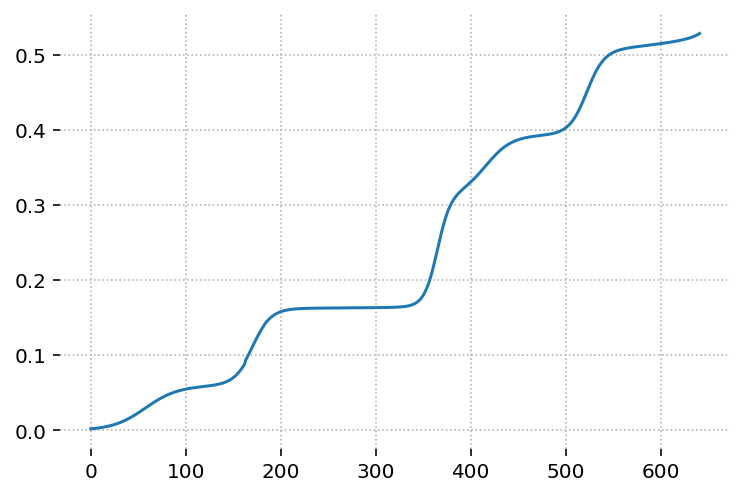

In [241]:
plt.plot(f.mean(0))

In [242]:
r.shape

(100, 31)

471

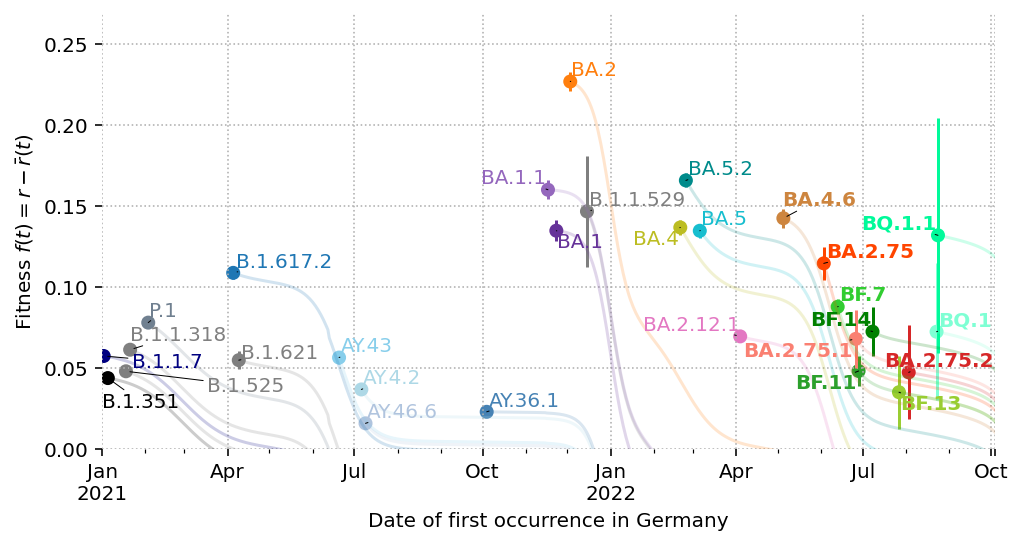

In [243]:
x = (GG[-1].cumsum(0)>0).argmax(0)
pd.Series(np.nan, index=np.arange("2021-01-01",np.datetime64('today'))).plot()
plt.xlim(("2021-01-01",np.datetime64('today')))
df = pd.DataFrame({"Growth advantage to Delta":r.mean(), "Relative growth advantage f":(r-f[:,x]).mean(0), "Lineage":merged_lineages_alias},index=cases_land.columns[x]).iloc[1:-1,:]
df["Relative growth advantage f"].plot(ls="", figsize=(8,4))
plt.errorbar(df.index, df["Relative growth advantage f"], yerr=2*(r-f[:,x]).std(0)[1:-1], ls="", c=[lineage_colors[x] for x in df.Lineage])
plt.scatter(df.index, df["Relative growth advantage f"], marker='o', c=[lineage_colors[x] for x in df.Lineage])
for i in range(df.shape[0]):
    j = merged_lineages_alias.index(df.Lineage[i])
    plt.plot(cases_land.columns[x[j]] + np.arange(f.shape[1]-x[j]).astype("timedelta64[D]"), (r[:,[j]]-f[:,x[j]:]).mean(0), c=lineage_colors[df.Lineage[i]], ls="-", alpha=0.2)
text=[]
for x,y,s in zip(df.index.tolist(), df["Relative growth advantage f"],df.Lineage.tolist()):
    text.append(plt.text(x,y,s, ha='left', va='center', color=lineage_colors[s]))
plt.xlabel("Date of first occurrence in Germany")
#plt.xlabel('')
plt.ylabel("Fitness $f(t) = r-\\bar{r}(t)$")
for l in text:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ"]),l.get_text()):
        l.set_weight('bold')
plt.ylim((0.00,None))
#secax = plt.gca().secondary_yaxis('right', functions=(lambda x: np.log(2)/x, lambda x: 1/np.log(2)/x))
#secax.set_ylabel('Doubling time')
#secax.set_yscale('log')
#secax.set_yticks(np.concatenate([np.arange(50,10,-10),np.arange(10,1,-1)]))
#secax.spines['right'].set_visible(False)
adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )

In [212]:
np.mean(model.posterior['c1'].squeeze(),0)

array([ -5.683878 ,  -3.801725 ,  -9.640736 ,  -8.048886 ,  -9.132423 ,
        -6.6548414,  -8.932465 , -12.239685 ,  -5.003436 ,  -9.279586 ,
        -7.0341477,  -1.2030137, -11.995223 , -10.299767 ,  -9.924448 ,
       -14.876024 ,  -4.923444 ,  -4.383931 ,  -1.1334453,  -5.216893 ,
        -0.3874015,  -2.1079495,  -6.213313 ,  -7.0789723,  -8.782627 ,
        -7.244208 ,  -5.720897 ,  -3.2563741,  -3.8259978,  -8.501337 ,
         0.       ], dtype=float32)

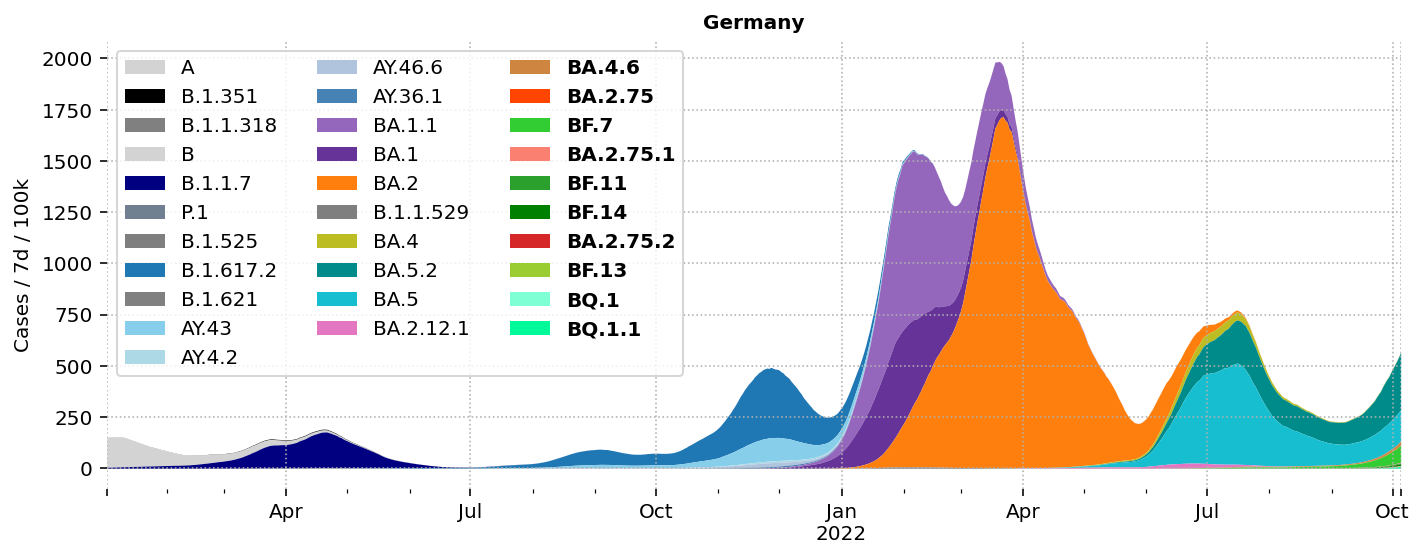

In [213]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:], columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,o].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
leg = ax[-1].legend(title=None, ncol=3, loc='upper left')
for l in leg.get_texts():
    if re.match("|".join(["BA.2.75", "BA.4.6","BF","BQ"]),l.get_text()):
        l.set_weight('bold')

plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

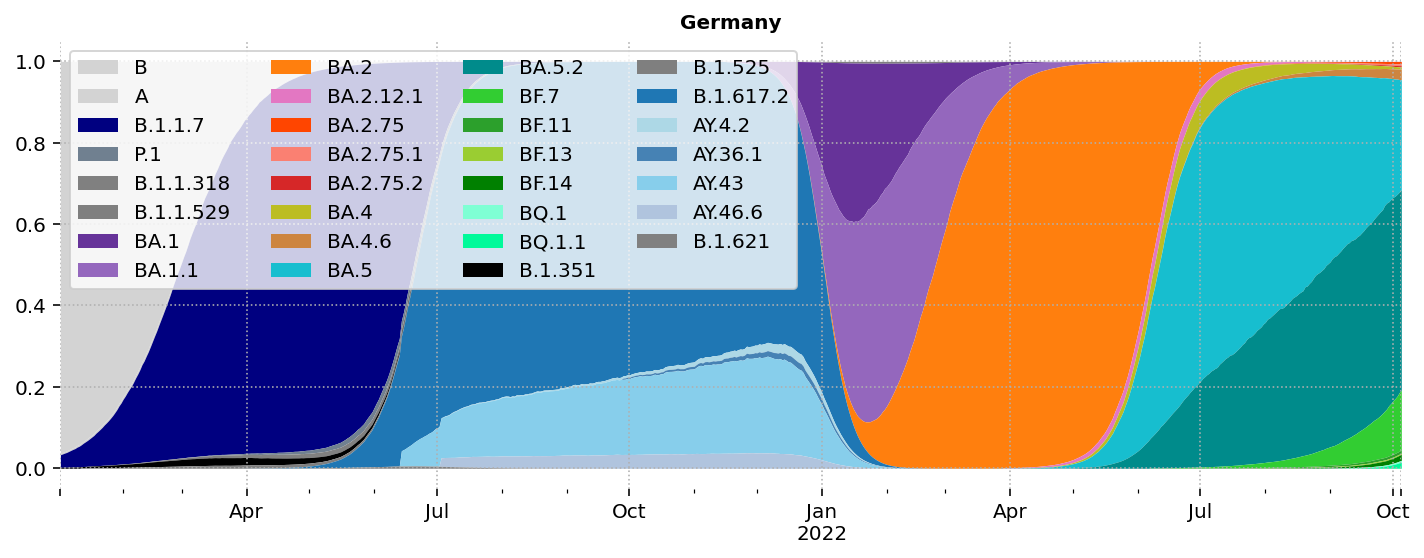

In [214]:
fig, ax = plt.subplots(1,1, figsize=(10,4), sharex=True, sharey=True)
ax = [ax]
#ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(["Germany"]):
    y = pd.DataFrame(λ[i,:,:]/λ[i].sum(-1, keepdims=True), columns=merged_lineages_alias, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    #y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)#* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]-1,-1,-1):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    #ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    #ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(loc='upper left', title=None, ncol=4)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [215]:
j

0

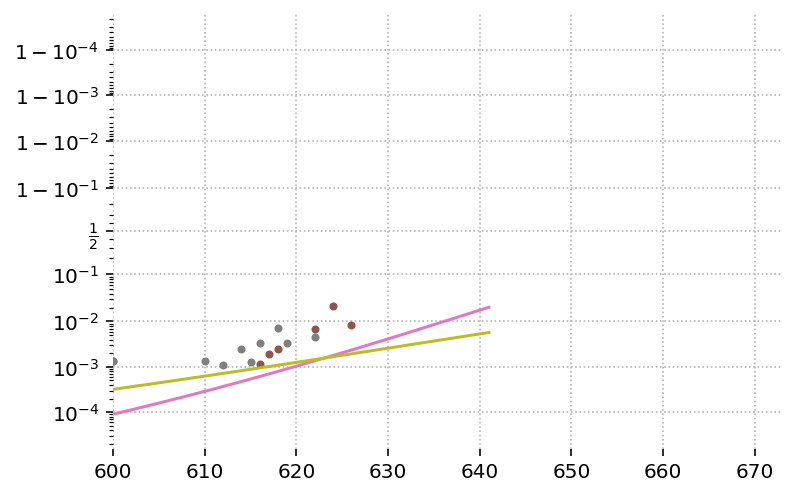

In [256]:
plt.plot(GG[-1,:,-1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,0]/GG[-1].sum(-1))
plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,-3]/GG[-1].sum(-1))
plt.plot(GG[-1,:,1]/GG[-1].sum(-1))
plt.plot(GG[-1,:,merged_lineages_alias.index("BQ.1.1")]/GG[-1].sum(-1), ls="", marker=".")
plt.plot(p[:,merged_lineages_alias.index("BQ.1.1")])
plt.plot(GG[-1,:,merged_lineages_alias.index("BQ.1")]/GG[-1].sum(-1), ls="", marker=".")
plt.plot(p[:,merged_lineages_alias.index("BQ.1")])
plt.xlim((600,None))
plt.yscale('logit')

In [253]:
p = model.get_probabilities().mean(0).squeeze()

In [254]:
p.shape

(642, 31)

In [124]:
dict(zip(merged_lineages_alias,model.posterior['c1'].squeeze().mean(0)))

{'A': -5.678625,
 'B.1.1.7': -3.82374,
 'P.1': -9.665182,
 'B.1.1.318': -8.046838,
 'B.1.1.529': -8.9980755,
 'BA.1': -6.751668,
 'BA.1.1': -9.045891,
 'BA.2': -12.3217945,
 'BA.2.12.1': -5.001399,
 'BA.2.75': -9.240113,
 'BA.2.75.1': -6.9650664,
 'BA.2.75.2': -1.2204207,
 'BA.4': -12.044202,
 'BA.4.6': -10.349425,
 'BA.5': -9.873872,
 'BA.5.2': -14.880224,
 'BF.7': -4.9217644,
 'BF.11': -4.33405,
 'BF.13': -1.1556995,
 'BF.14': -5.16616,
 'BQ.1.1': -1.2069445,
 'B.1.351': -6.2202086,
 'B.1.525': -7.0617213,
 'B.1.617.2': -8.874443,
 'AY.4.2': -7.2629957,
 'AY.36.1': -5.7352815,
 'AY.43': -3.2769134,
 'AY.46.6': -3.833556,
 'B.1.621': -8.591097,
 'B': 0.0}

In [125]:
1/(1+np.exp(-2))

0.8807970779778823

In [126]:
c = model.posterior['c1'].mean(0)
b = model.posterior['b1'].mean(0)
c.shape

(1, 1, 30)

In [127]:
b.shape

(1, 1, 30)

In [128]:
t,g = model.clock()

In [129]:
l0 = t * b + g + c

(-20.0, 100.0)

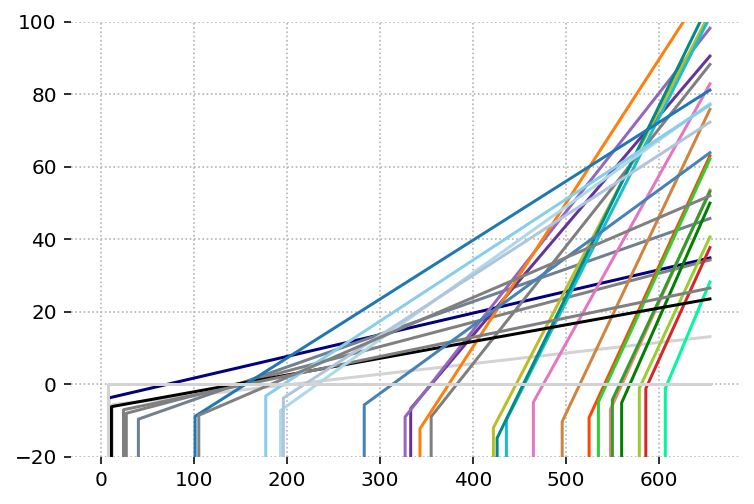

In [130]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))


In [131]:
lb = np.einsum('ji,jil->jl',
                    logsumexp(l0, -1), #jnp.max(logits,-1),
                    (t==0) * (g==0))

In [132]:
lb

array([[3.2701541e-02, 2.1610733e-02, 1.5346856e-01, 7.5790055e-02,
        3.2397175e+01, 2.8822374e+01, 2.7847439e+01, 3.0447275e+01,
        5.0272385e+01, 6.0618702e+01, 6.8922859e+01, 8.3972267e+01,
        4.3284496e+01, 5.5311600e+01, 4.5559570e+01, 4.3934513e+01,
        6.3883785e+01, 6.9712814e+01, 8.1198524e+01, 7.3670799e+01,
        9.2293770e+01, 2.7733440e-02, 6.4043134e-02, 1.9359863e+00,
        7.5563097e+00, 2.0698547e+01, 6.3834925e+00, 7.8172922e+00,
        2.1423068e+00, 0.0000000e+00]], dtype=float32)

(-20.0, 100.0)

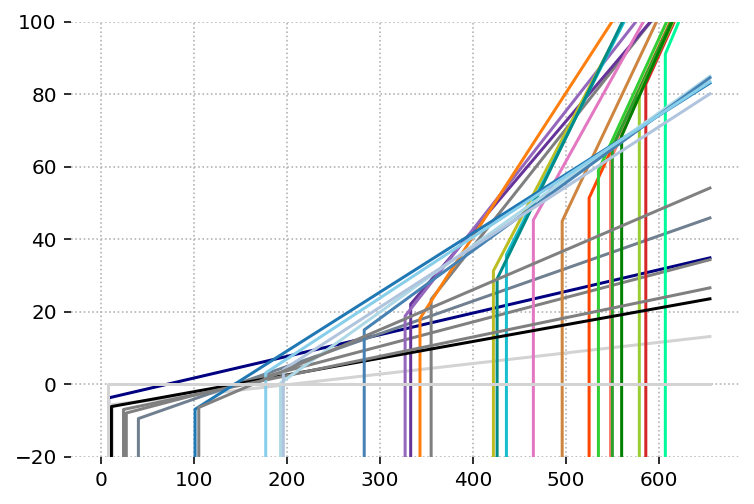

In [133]:
for i in range(l0.shape[-1]):
    plt.plot(l0[0,...,i]+lb[0,i], c=lineage_colors[merged_lineages_alias[i]])
plt.ylim((-20,100))

In [134]:
bak.loc[bak.index.str.startswith("B.1"),:]

counts       date
B.1.1.7      97128 2021-01-11
B.1.617.2    20390 2021-04-12
B.1.177.86    3505 2021-01-08
B.1.177.81    3064 2021-01-08
B.1.177       2792 2021-01-04
B.1           2519 2021-01-06
B.1.221       2370 2021-01-05
B.1.160       2077 2021-01-04
B.1.351       1941 2021-01-18
B.1.1         1915 2021-01-06
B.1.258       1885 2021-01-09
B.1.1.529     1451 2022-01-06
B.1.1.317     1234 2021-01-16
B.1.177.62     903 2021-01-12
B.1.525        860 2021-02-01
B.1.258.17     749 2021-01-18
B.1.1.318      520 2021-02-19
B.1.1.70       426 2021-01-11
B.1.177.75     301 2021-01-08
B.1.1.385      277 2021-01-12
B.1.619        239 2021-03-17
B.1.1.39       232 2021-01-14
B.1.1.519      232 2021-02-08
B.1.1.297      224 2021-01-14
B.1.2          208 2021-01-20
B.1.221.2      191 2021-01-07
B.1.177.77     163 2021-01-12
B.1.9.4        161 2021-01-20
B.1.177.83     152 2021-01-25

In [245]:
pd.Series(GG[-1].sum(0), index=merged_lineages_alias)

A               693.0
B.1.1.7       97698.0
P.1             923.0
B.1.1.318      1173.0
B.1.1.529      1526.0
BA.1          57444.0
BA.1.1       109826.0
BA.2         261238.0
BA.2.12.1      3922.0
BA.2.75          90.0
BA.2.75.1        43.0
BA.2.75.2        29.0
BA.4           6430.0
BA.4.6          716.0
BA.5          73992.0
BA.5.2        36461.0
BF.7           1919.0
BF.11           160.0
BF.13            46.0
BF.14            86.0
BQ.1             20.0
BQ.1.1           12.0
B.1.351        1975.0
B.1.525         860.0
B.1.617.2    175404.0
AY.4.2         3098.0
AY.36.1        2221.0
AY.43         49174.0
AY.46.6        8701.0
B.1.621         165.0
B             30570.0
dtype: float64